In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from numpy import interp
from scipy.stats import boxcox

from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, make_scorer, auc, average_precision_score, precision_score, roc_curve, precision_recall_curve, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check raw data
raw_data = pd.read_csv("/kaggle/input/cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv")
raw_data.head(7)

# Find the number of missing entries in each column
data_with_null =raw_data.replace('?', np.nan)
data_with_null.isnull().sum() 

# Remove the two columns with 787 missing entries
sparsity_removed_data = data_with_null.drop(columns = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'])
sparsity_removed_data.shape

# Count number of missing entries in each row
missing_entries = sparsity_removed_data.isnull().sum(axis=1).tolist()

# Group rows with the same number of missing entries
null_mapping = dict((x, missing_entries.count(x)) for x in missing_entries)
sorted(null_mapping.items())

# Remove all the rows with any null entries
null_removed_data = sparsity_removed_data.dropna()
null_removed_data.isnull().sum()

# All categorical columns
object_cols = [col for col in null_removed_data.columns if null_removed_data[col].dtype == "object"]

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: null_removed_data[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

# Convert all categorical columns to float data
column_new_dtypes = {key: 'float64' for key in d}
df = null_removed_data.astype(column_new_dtypes)
df.info()

#df = null_removed_data.apply(pd.to_numeric)
#df.info()

# Get details of the null removed data, i.e., Mean, Min, Max etc
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 668 non-null    int64  
 1   Number of sexual partners           668 non-null    float64
 2   First sexual intercourse            668 non-null    float64
 3   Num of pregnancies                  668 non-null    float64
 4   Smokes                              668 non-null    float64
 5   Smokes (years)                      668 non-null    float64
 6   Smokes (packs/year)                 668 non-null    float64
 7   Hormonal Contraceptives             668 non-null    float64
 8   Hormonal Contraceptives (years)     668 non-null    float64
 9   IUD                                 668 non-null    float64
 10  IUD (years)                         668 non-null    float64
 11  STDs                                668 non-n

Age  Number of sexual partners  First sexual intercourse  \
count  668.000000                 668.000000                668.000000   
mean    27.264970                   2.523952                 17.142216   
std      8.727432                   1.640299                  2.852046   
min     13.000000                   1.000000                 10.000000   
25%     21.000000                   2.000000                 15.000000   
50%     26.000000                   2.000000                 17.000000   
75%     33.000000                   3.000000                 18.000000   
max     84.000000                  28.000000                 32.000000   

       Num of pregnancies      Smokes  Smokes (years)  Smokes (packs/year)  \
count          668.000000  668.000000      668.000000           668.000000   
mean             2.323353    0.143713        1.235524             0.458953   
std              1.465319    0.351061        4.193611             2.336308   
min              0.000000    0.000000        0.000000             0.000000   
25%              1.000000    0.000000        0.000000             0.000000   
50%              2.000000    0.000000        0.000000             0.000000   
75%              3.000000    0.000000        0.000000             0.000000   
max             11.000000    1.000000       37.000000            37.000000   

       Hormonal Contraceptives  Hormonal Contraceptives (years)         IUD  \
count               668.000000                       668.000000  668.000000   
mean                  0.643713                         2.290037    0.112275   
std                   0.479260                         3.724400    0.315942   
min                   0.000000                         0.000000    0.000000   
25%                   0.000000                         0.000000    0.000000   
50%                   1.000000                         0.500000    0.000000   
75%                   1.000000                         3.000000    0.000000   
max                   1.000000                        22.000000    1.000000   

       ...    STDs:HPV  STDs: Number of diagnosis   Dx:Cancer      Dx:CIN  \
count  ...  668.000000                 668.000000  668.000000  668.000000   
mean   ...    0.002994                   0.092814    0.025449    0.004491   
std    ...    0.054677                   0.310355    0.157603    0.066915   
min    ...    0.000000                   0.000000    0.000000    0.000000   
25%    ...    0.000000                   0.000000    0.000000    0.000000   
50%    ...    0.000000                   0.000000    0.000000    0.000000   
75%    ...    0.000000                   0.000000    0.000000    0.000000   
max    ...    1.000000                   3.000000    1.000000    1.000000   

           Dx:HPV          Dx  Hinselmann    Schiller    Citology      Biopsy  
count  668.000000  668.000000  668.000000  668.000000  668.000000  668.000000  
mean     0.023952    0.023952    0.044910    0.094311    0.058383    0.067365  
std      0.153015    0.153015    0.207262    0.292480    0.234642    0.250841  
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000  

[8 rows x 34 columns]

In [4]:
# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('STDs:cervical condylomatosis', 1),
 ('STDs:AIDS', 1),
 ('Smokes', 2),
 ('Hormonal Contraceptives', 2),
 ('IUD', 2),
 ('STDs', 2),
 ('STDs:condylomatosis', 2),
 ('STDs:vaginal condylomatosis', 2),
 ('STDs:vulvo-perineal condylomatosis', 2),
 ('STDs:syphilis', 2),
 ('STDs:pelvic inflammatory disease', 2),
 ('STDs:genital herpes', 2),
 ('STDs:molluscum contagiosum', 2),
 ('STDs:HIV', 2),
 ('STDs:Hepatitis B', 2),
 ('STDs:HPV', 2),
 ('STDs (number)', 5),
 ('Number of sexual partners', 9),
 ('Num of pregnancies', 11),
 ('First sexual intercourse', 21),
 ('IUD (years)', 25),
 ('Smokes (years)', 30),
 ('Hormonal Contraceptives (years)', 38),
 ('Smokes (packs/year)', 53)]

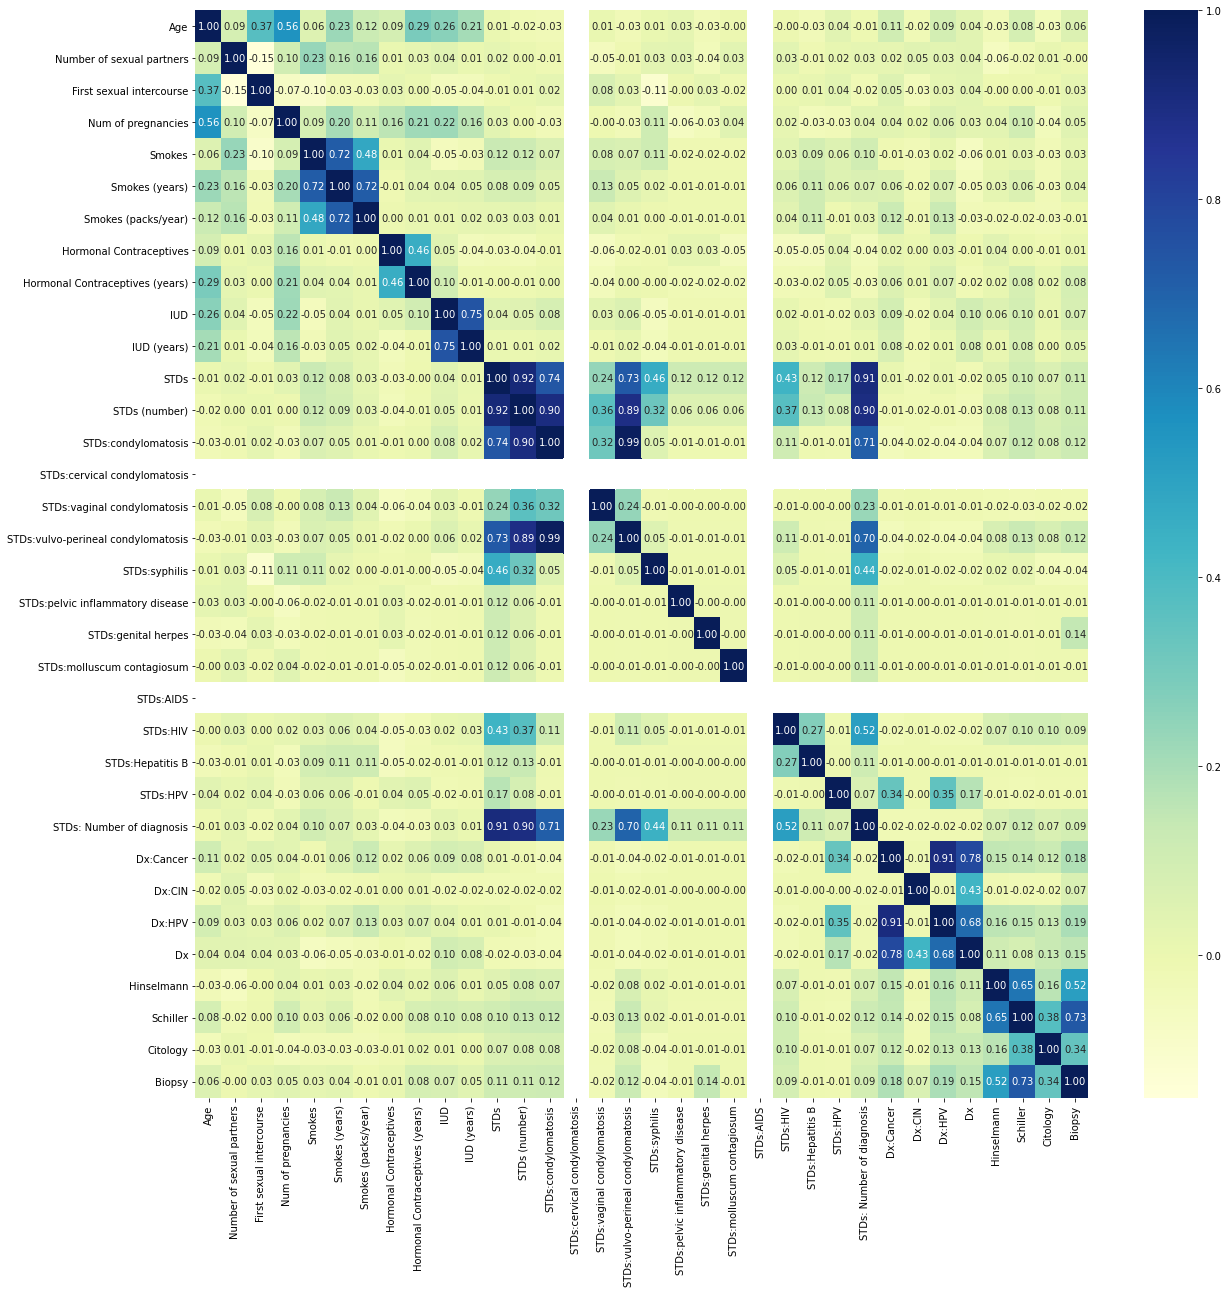

In [5]:
# Correlation Matrix for each features
corrmat = round(df.corr(), 2)
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,fmt='.2f',cmap="YlGnBu")

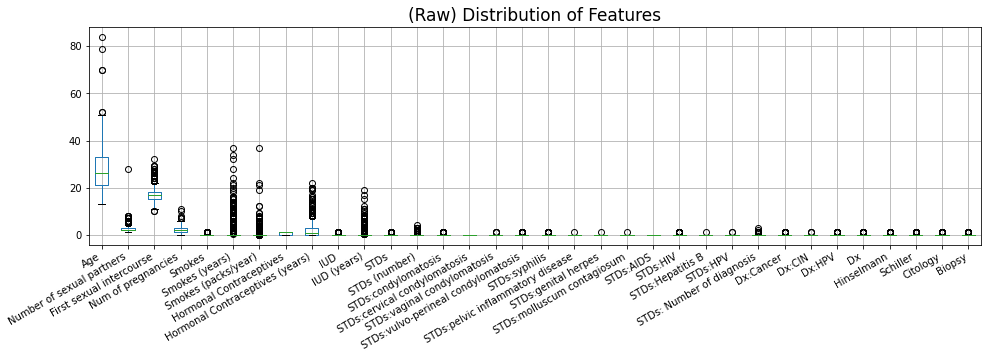

In [6]:
# BoxPlot showing raw distribution of features
plt.figure(figsize=(16,4))
df.iloc[:,:].boxplot()
plt.title('(Raw) Distribution of Features', fontsize=17)
# Get current axes
ax = plt.gca()
# Make space for and rotate the x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [7]:
df.mode()

Age  Number of sexual partners  First sexual intercourse  \
0   23                        2.0                      15.0   

   Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                 1.0     0.0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (years)  IUD  ...  \
0                      1.0                              0.0  0.0  ...   

   STDs:HPV  STDs: Number of diagnosis  Dx:Cancer  Dx:CIN  Dx:HPV  Dx  \
0       0.0                          0          0       0       0   0   

   Hinselmann  Schiller  Citology  Biopsy  
0           0         0         0       0  

[1 rows x 34 columns]

In [8]:
df.median()

Age                                   26.0
Number of sexual partners              2.0
First sexual intercourse              17.0
Num of pregnancies                     2.0
Smokes                                 0.0
Smokes (years)                         0.0
Smokes (packs/year)                    0.0
Hormonal Contraceptives                1.0
Hormonal Contraceptives (years)        0.5
IUD                                    0.0
IUD (years)                            0.0
STDs                                   0.0
STDs (number)                          0.0
STDs:condylomatosis                    0.0
STDs:cervical condylomatosis           0.0
STDs:vaginal condylomatosis            0.0
STDs:vulvo-perineal condylomatosis     0.0
STDs:syphilis                          0.0
STDs:pelvic inflammatory disease       0.0
STDs:genital herpes                    0.0
STDs:molluscum contagiosum             0.0
STDs:AIDS                              0.0
STDs:HIV                               0.0
STDs:Hepati

In [9]:
# Remove outliers
df.drop(df.index[df['Age'] > 52], inplace = True)
df.drop(df.index[df['Number of sexual partners'] > 8], inplace = True)

In [10]:

# Define target variables and remove target columns from data
y1 = df.Hinselmann
y2 = df.Schiller
y3 = df.Citology
y4 = df.Biopsy
X = df.drop(['Hinselmann', 'Schiller', 'Citology', 'Biopsy'], axis=1)

# Count number of class 1 and class 0 samples for each target
print('_' * 30)
print("Capturing Class Imbalance")
print(y1.value_counts())
print(y2.value_counts())
print(y3.value_counts())
print(y4.value_counts())

t1 = sparsity_removed_data.Hinselmann
t2 = sparsity_removed_data.Schiller
t3 = sparsity_removed_data.Citology
t4 = sparsity_removed_data.Biopsy

# Count number of class 1 and class 0 samples for each target
print('_' * 30)
print("Data with null values:")
print(t1.value_counts())
print(t2.value_counts())
print(t3.value_counts())
print(t4.value_counts())


______________________________
Capturing Class Imbalance
0    633
1     30
Name: Hinselmann, dtype: int64
0    601
1     62
Name: Schiller, dtype: int64
0    624
1     39
Name: Citology, dtype: int64
0    618
1     45
Name: Biopsy, dtype: int64
______________________________
Data with null values:
0    823
1     35
Name: Hinselmann, dtype: int64
0    784
1     74
Name: Schiller, dtype: int64
0    814
1     44
Name: Citology, dtype: int64
0    803
1     55
Name: Biopsy, dtype: int64


In [11]:
# Convert age to Age groups - Min age: 13, Max age: 52
# 10 to 14 --> Group 1
# 15 to 19 --> Group 2
# ...
# 50 to 54 --> Group 9

age_bins = np.arange(9, 55 , 5)
age_labels = np.arange(1, 10)
X['age_group'] = pd.cut(X.Age, bins = age_bins, labels = age_labels)
X['age_group'] =  pd.to_numeric(X['age_group'])

# df[['Age','age_group']].head(20)

In [12]:
# Similarly convert first sexual intercourse age, Min age: 10, Max age: 32
fsi_bins = np.arange(9, 35 , 5)
fsi_labels = np.arange(1, 6)
X['fsi_group'] = pd.cut(X['First sexual intercourse'], bins = fsi_bins, labels = fsi_labels)
X['fsi_group'] =  pd.to_numeric(X['fsi_group'])

# df[['Age', 'First sexual intercourse', 'fsi_group']].head(20)

In [13]:
# Drop Age, First Sexual Intercourse columns
X = X.drop(columns=['Age', 'First sexual intercourse'], axis=1)

In [14]:
X.nunique(axis=0).sort_values()

STDs:cervical condylomatosis           1
STDs:AIDS                              1
STDs:vulvo-perineal condylomatosis     2
STDs:molluscum contagiosum             2
STDs:genital herpes                    2
STDs:pelvic inflammatory disease       2
STDs:syphilis                          2
STDs:Hepatitis B                       2
STDs:vaginal condylomatosis            2
STDs:condylomatosis                    2
STDs:HPV                               2
IUD                                    2
Dx:Cancer                              2
Hormonal Contraceptives                2
Dx:CIN                                 2
Dx:HPV                                 2
Smokes                                 2
Dx                                     2
STDs                                   2
STDs:HIV                               2
STDs: Number of diagnosis              4
fsi_group                              5
STDs (number)                          5
Number of sexual partners              8
Num of pregnanci

In [15]:
# Remove columns with only one unique value
X = X.drop(['STDs:cervical condylomatosis', 'STDs:AIDS'], axis=1)

In [16]:
# sns.relplot(x="Number of sexual partners", y=y1.name, data=df);

In [17]:
from sklearn.feature_selection import mutual_info_classif

"""def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y1)
positive_mi = mi_scores[mi_scores != 0]
positive_mi

"""


'def make_mi_scores(X, y):\n    mi_scores = mutual_info_classif(X, y)\n    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)\n    mi_scores = mi_scores.sort_values(ascending=False)\n    return mi_scores\n\nmi_scores = make_mi_scores(X, y1)\npositive_mi = mi_scores[mi_scores != 0]\npositive_mi\n\n'

In [18]:
"""def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(positive_mi)"""

'def plot_mi_scores(scores):\n    scores = scores.sort_values(ascending=True)\n    width = np.arange(len(scores))\n    ticks = list(scores.index)\n    plt.barh(width, scores)\n    plt.yticks(width, ticks)\n    plt.title("Mutual Information Scores")\n\n\nplt.figure(dpi=100, figsize=(8, 5))\nplot_mi_scores(positive_mi)'

In [19]:
"""norm_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse', 
                'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 
               'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)',
               'STDs: Number of diagnosis']

X.hist(figsize=(15,15))"""

"norm_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse', \n                'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', \n               'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)',\n               'STDs: Number of diagnosis']\n\nX.hist(figsize=(15,15))"

In [20]:
# Normalise Age
"""X['Age Norm'] = boxcox(X['Age'], 0.5)
X.hist('Age Norm')"""

"X['Age Norm'] = boxcox(X['Age'], 0.5)\nX.hist('Age Norm')"

In [21]:
from scipy.special import boxcox1p

# Normalise Age
"""X['Num of pregnancies (Norm)'] = boxcox1p(X['Num of pregnancies'], 0.7)
X.hist('Num of pregnancies (Norm)')"""

"X['Num of pregnancies (Norm)'] = boxcox1p(X['Num of pregnancies'], 0.7)\nX.hist('Num of pregnancies (Norm)')"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c6e88eb50>,
      dtype=object)

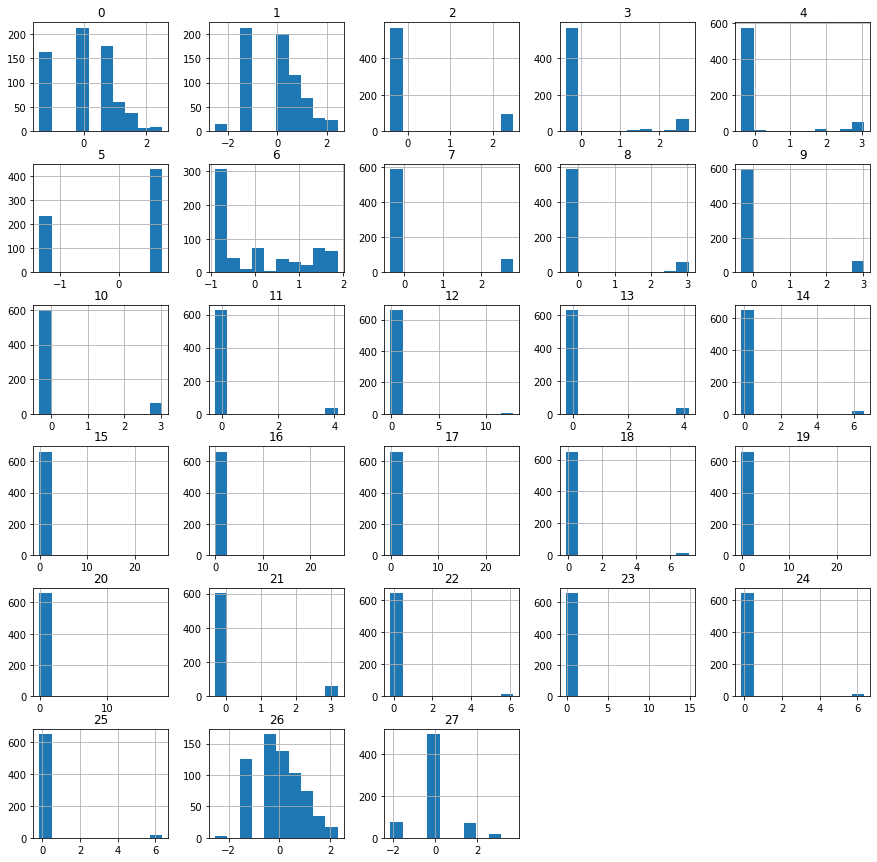

In [22]:
# First regularize data b/w 1 and 2
scaler = MinMaxScaler(feature_range=(1, 2))

# Use PowerTransformer to normalize data
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
Xnorm = pipeline.fit_transform(X)

Xnorm = pd.DataFrame(Xnorm)
Xnorm.hist(figsize=(15,15))
#result_df = df1.apply(lambda col: stats.boxcox(col, a.loc[col.name]))

In [23]:
Xnorm.columns = X.columns

In [24]:
X_columns = X.columns.tolist()
X_columns

['Number of sexual partners',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV',
 'STDs: Number of diagnosis',
 'Dx:Cancer',
 'Dx:CIN',
 'Dx:HPV',
 'Dx',
 'age_group',
 'fsi_group']

In [25]:
"""#feat_name = 'STDs:condylomatosis'
for ft_name in X_columns:

    # Frequency distribution of Age
    print(X.groupby([ft_name]).size())
    
    for tes in [y1.name, y2.name, y3.name, y4.name]:
        print(tes)
        hins_age = df.loc[df[tes] == 1]
        print(hins_age.groupby([ft_name]).size())"""

"#feat_name = 'STDs:condylomatosis'\nfor ft_name in X_columns:\n\n    # Frequency distribution of Age\n    print(X.groupby([ft_name]).size())\n    \n    for tes in [y1.name, y2.name, y3.name, y4.name]:\n        print(tes)\n        hins_age = df.loc[df[tes] == 1]\n        print(hins_age.groupby([ft_name]).size())"

In [26]:
"""for tes in [y1.name, y2.name, y3.name, y4.name]:
    print(tes)
    hins_age = df.loc[df[tes] == 1]
    hins_age.groupby([feat_name]).size()"""

'for tes in [y1.name, y2.name, y3.name, y4.name]:\n    print(tes)\n    hins_age = df.loc[df[tes] == 1]\n    hins_age.groupby([feat_name]).size()'

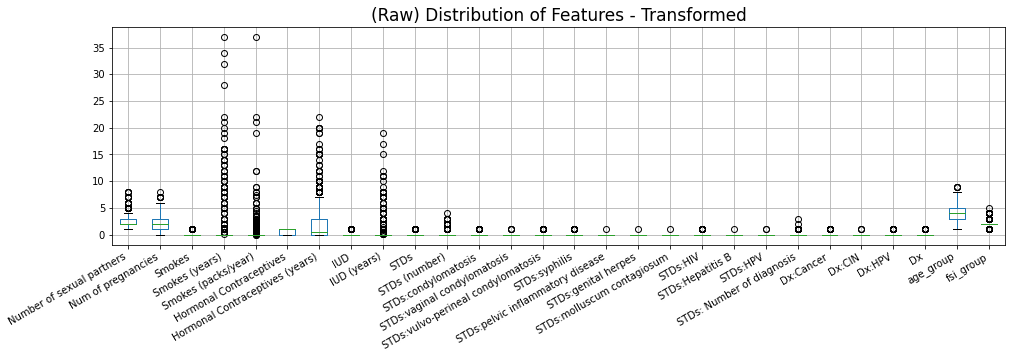

In [27]:
# BoxPlot showing raw distribution of features
plt.figure(figsize=(16,4))
X.iloc[:,:].boxplot()
plt.title('(Raw) Distribution of Features - Transformed', fontsize=17)
# Get current axes
ax = plt.gca()
# Make space for and rotate the x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

One of the most important step while working with highly imbalanced dataset is to balance the classes. There are several tecniques which provide a mechanism for balancing the dataset. These involve Random undersampling of the majority class, Oversampling of the minority class, Cluster based Oversampling and Synthetic Minority Oversampling Technique (SMOTE). Here we will use SMOTE.

In [28]:
# Balance Classes
# Join the train data
train1 = Xnorm.join(y1)
train2 = Xnorm.join(y2)
train3 = Xnorm.join(y3)
train4 = Xnorm.join(y4)

#print('Data (Hinselmann) shape before balancing:',len(train1))
print('\nCounts of positive VS negative (Hinselmann) in original data:')
print(train1.Hinselmann.value_counts())
print('-'*40)

#print('Data (Schiller) shape before balancing:',train2.shape)
print('\nCounts of positive VS negative (Schiller) in original data:')
print(train2.Schiller.value_counts())
print('-'*40)

#print('Data (Citology) shape before balancing:',train3.shape)
print('\nCounts of positive VS negative (Citology) in original data:')
print(train3.Citology.value_counts())
print('-'*40)

#print('Data (Biopsy) shape before balancing:',train4.shape)
print('\nCounts of positive VS negative (Biopsy) in original data:')
print(train4.Biopsy.value_counts())
print('-'*40)


Counts of positive VS negative (Hinselmann) in original data:
0.0    506
1.0     27
Name: Hinselmann, dtype: int64
----------------------------------------

Counts of positive VS negative (Schiller) in original data:
0.0    486
1.0     47
Name: Schiller, dtype: int64
----------------------------------------

Counts of positive VS negative (Citology) in original data:
0.0    504
1.0     29
Name: Citology, dtype: int64
----------------------------------------

Counts of positive VS negative (Biopsy) in original data:
0.0    500
1.0     33
Name: Biopsy, dtype: int64
----------------------------------------


In [29]:
y1.name

'Hinselmann'

In [30]:
# Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
X1_bal, y1_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    Xnorm,
    y1)

# Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
X2_bal, y2_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    Xnorm,
    y2)

# Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
X3_bal, y3_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    Xnorm,
    y3)

# Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
X4_bal, y4_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    Xnorm,
    y4)

# Join X and y
X1_bal = pd.DataFrame(X1_bal,columns=Xnorm.columns)
y1_bal = pd.DataFrame(y1_bal,columns=['Hinselmann'])
balanced1 = X1_bal.join(y1_bal)

# Join X and y
X2_bal = pd.DataFrame(X2_bal,columns=Xnorm.columns)
y2_bal = pd.DataFrame(y2_bal,columns=['Schiller'])
balanced2 = X2_bal.join(y2_bal)

# Join X and y
X3_bal = pd.DataFrame(X3_bal,columns=Xnorm.columns)
y3_bal = pd.DataFrame(y3_bal,columns=['Citology'])
balanced3 = X3_bal.join(y3_bal)

# Join X and y
X4_bal = pd.DataFrame(X4_bal,columns=Xnorm.columns)
y4_bal = pd.DataFrame(y4_bal,columns=['Biopsy'])
balanced4 = X4_bal.join(y4_bal)


print('-'*40)
print('Data (Hinselmann) shape after balancing:',balanced1.shape)
print('\nCounts of positive VS negative in new data:')
print(balanced1.Hinselmann.value_counts())

print('-'*40)
print('Data (Schiller) shape after balancing:',balanced2.shape)
print('\nCounts of positive VS negative in new data:')
print(balanced2.Schiller.value_counts())

print('-'*40)
print('Data (Citology) shape after balancing:',balanced3.shape)
print('\nCounts of positive VS negative in new data:')
print(balanced3.Citology.value_counts())

print('-'*40)
print('Data (Biopsy) shape after balancing:',balanced4.shape)
print('\nCounts of positive VS negative in new data:')
print(balanced4.Biopsy.value_counts())

----------------------------------------
Data (Hinselmann) shape after balancing: (1265, 29)

Counts of positive VS negative in new data:
0    633
1    632
Name: Hinselmann, dtype: int64
----------------------------------------
Data (Schiller) shape after balancing: (1189, 29)

Counts of positive VS negative in new data:
0    601
1    588
Name: Schiller, dtype: int64
----------------------------------------
Data (Citology) shape after balancing: (1244, 29)

Counts of positive VS negative in new data:
0    624
1    620
Name: Citology, dtype: int64
----------------------------------------
Data (Biopsy) shape after balancing: (1248, 29)

Counts of positive VS negative in new data:
1    630
0    618
Name: Biopsy, dtype: int64


In [31]:
y1_bal.columns.name = 'Hinselmann'
y2_bal.columns.name = 'Schiller'
y3_bal.columns.name = 'Citology'
y4_bal.columns.name = 'Biopsy'

targets = [y1_bal.columns.name, y2_bal.columns.name, y3_bal.columns.name, y4_bal.columns.name]

In [32]:

def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    """
    Draw a Cross Validated ROC Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    Example largely taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    # Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = 0
    std_auc = 0

    i = 0
    for train, test in cv.split(X, y):
        
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return mean_auc


In [33]:
def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series

    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []

    i = 0
    for train, test in cv.split(X, y):
        trainer = classifier.fit(X.iloc[train], y.iloc[train])
        probas_ = trainer.predict_proba(X.iloc[test])
        
        #plot_importance(xgbc)
        #print(get_feature_importance(trainer))
        
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        
        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y.iloc[test], probas_[:, 1])))

        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        i += 1

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)

    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    pr_auc = average_precision_score(y_real, y_proba)
    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (pr_auc),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return pr_auc

In [34]:
# Setting up simple RF Classifier
rfc = RandomForestClassifier(random_state=42)

xgbc = XGBClassifier(n_estimators=10, 
                     max_depth=5, 
                     learning_rate=0.4, 
                     random_state=42)

svc = Pipeline([ ("pre", preprocessing.StandardScaler()), 
                    ("classifier", SVC(C=1, 
                                       probability=True, random_state=42))])

knn = KNeighborsClassifier()

clfs = [svc, rfc, knn, xgbc]

In [35]:
cvs = []
for split_value in [4, 5, 6, 7, 8, 9]:
    # Set up Stratified K Fold
    cvs.append(StratifiedKFold(n_splits=split_value, random_state=0))


In [36]:
cvs[1].n_splits

5

In [37]:
def get_classifier_name(clf):
    cn = clf.__class__.__name__
    class_name = cn if (cn != 'Pipeline') else 'SVC'
    return class_name

______________________________ 

 SVC 
 ______________________________


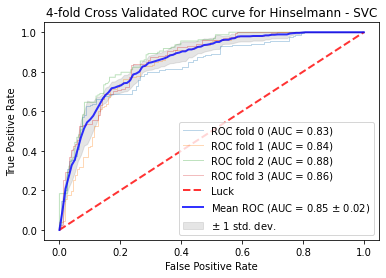

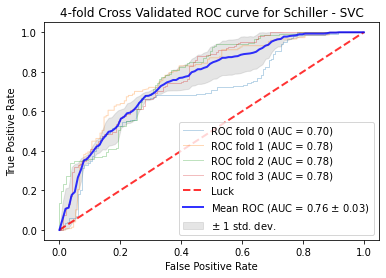

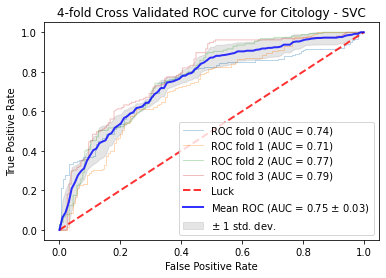

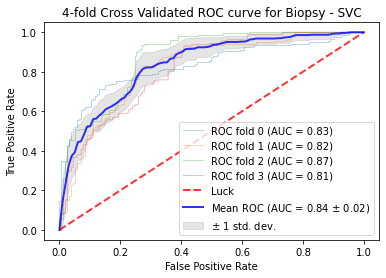

______________________________ 

 SVC 
 ______________________________


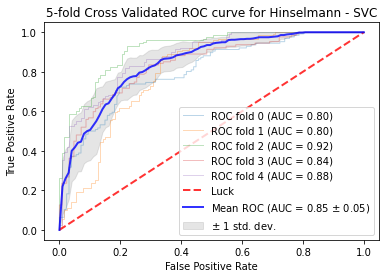

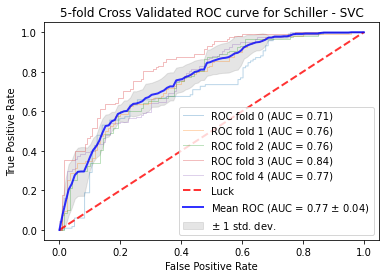

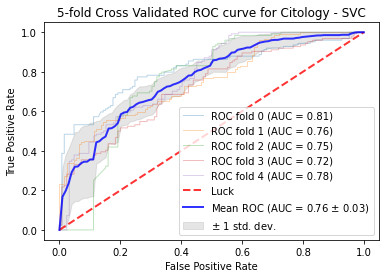

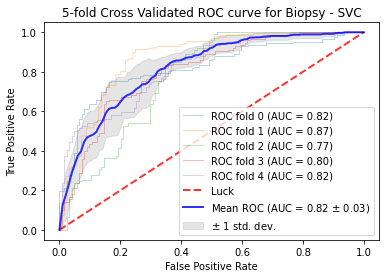

______________________________ 

 SVC 
 ______________________________


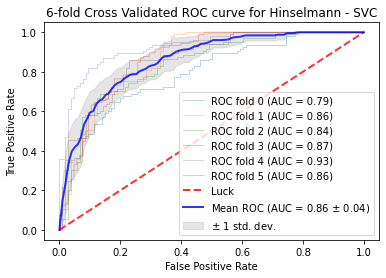

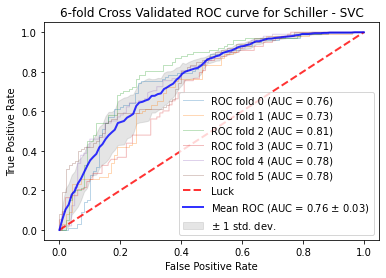

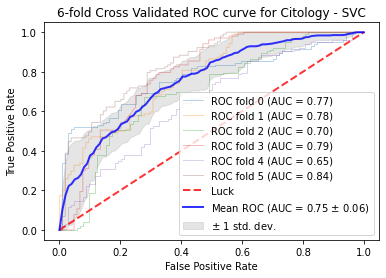

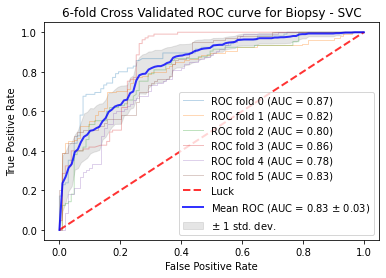

______________________________ 

 SVC 
 ______________________________


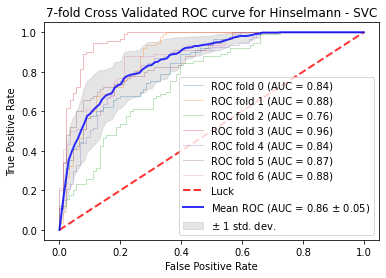

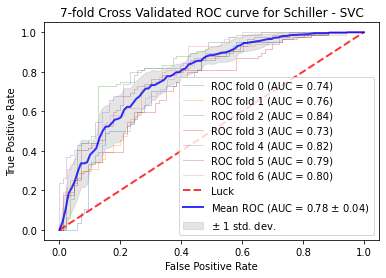

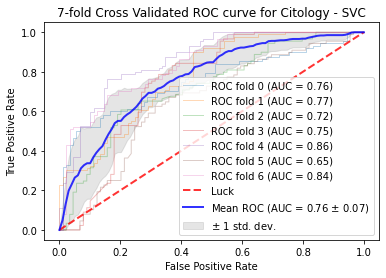

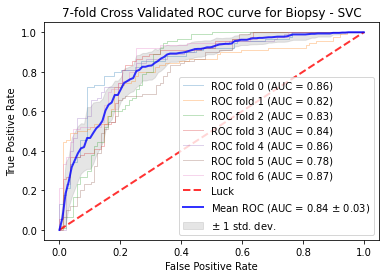

______________________________ 

 SVC 
 ______________________________


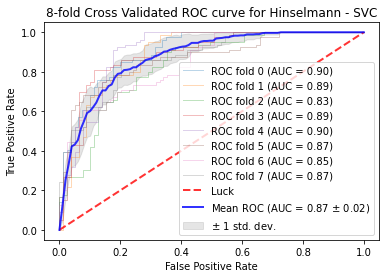

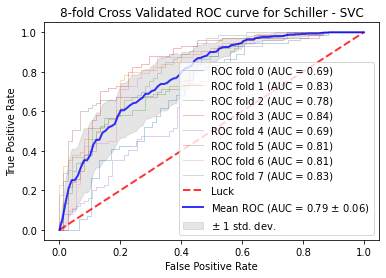

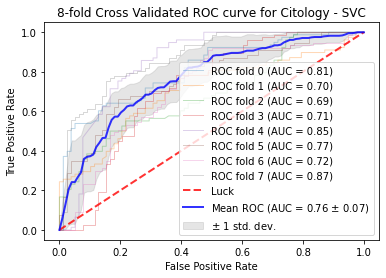

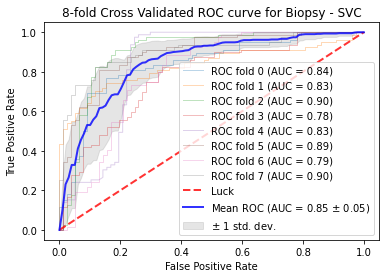

______________________________ 

 SVC 
 ______________________________


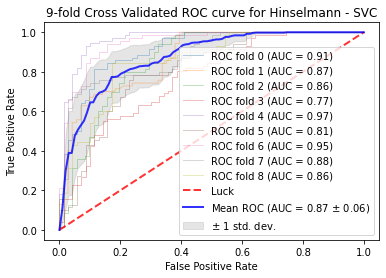

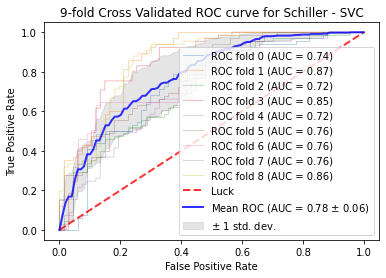

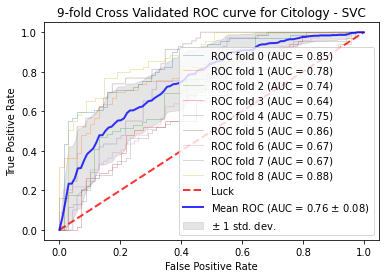

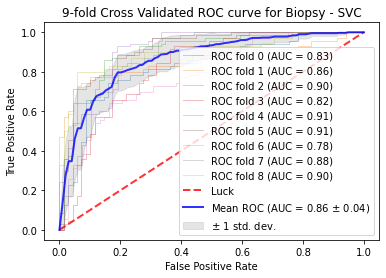

______________________________ 

 RandomForestClassifier 
 ______________________________


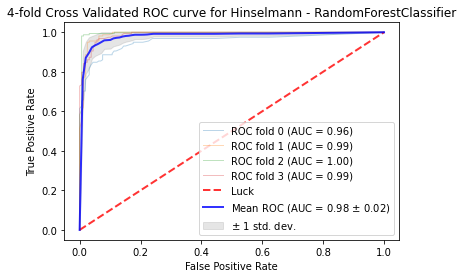

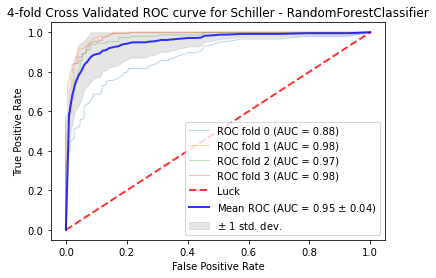

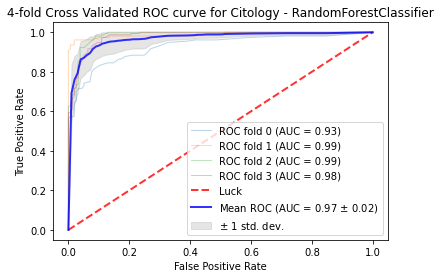

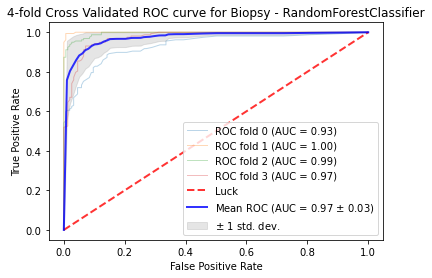

______________________________ 

 RandomForestClassifier 
 ______________________________


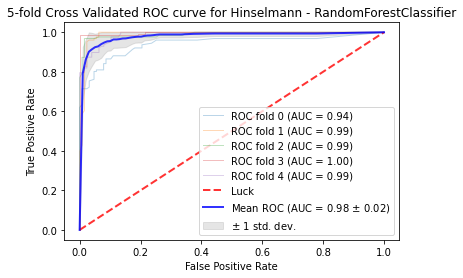

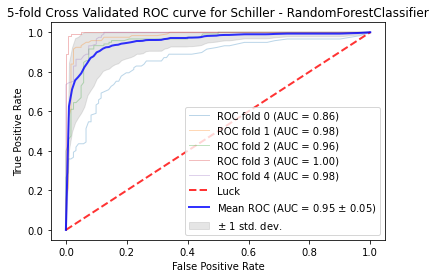

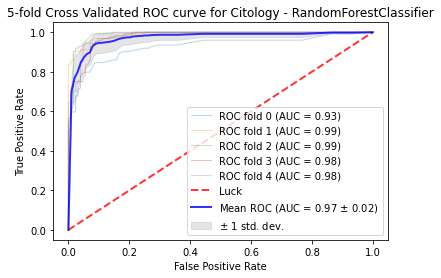

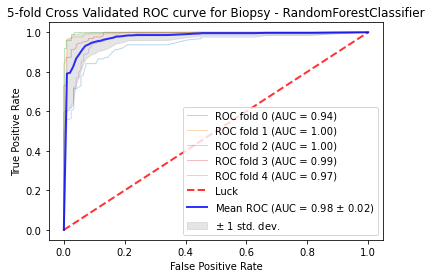

______________________________ 

 RandomForestClassifier 
 ______________________________


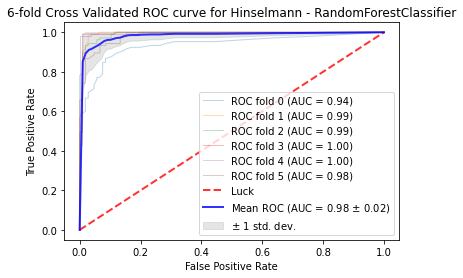

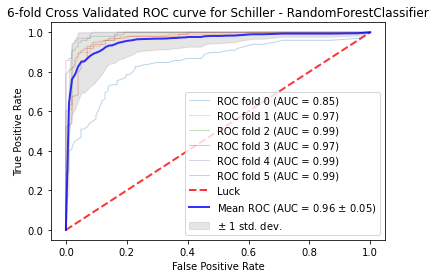

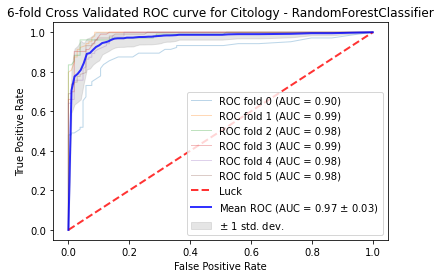

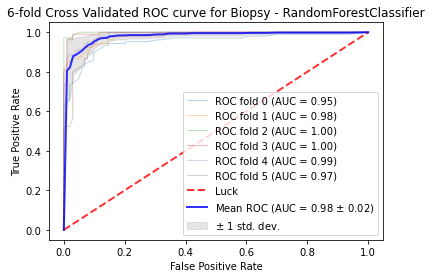

______________________________ 

 RandomForestClassifier 
 ______________________________


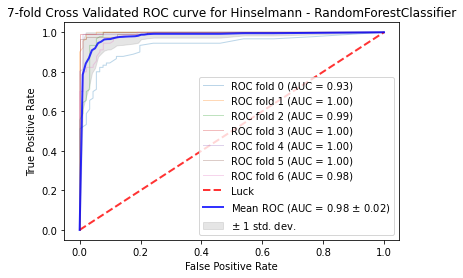

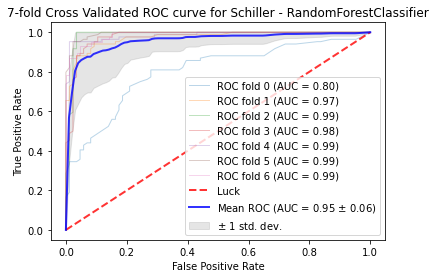

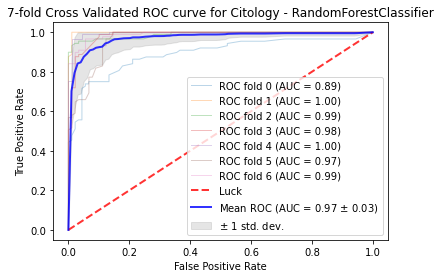

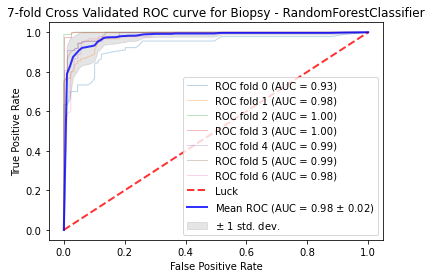

______________________________ 

 RandomForestClassifier 
 ______________________________


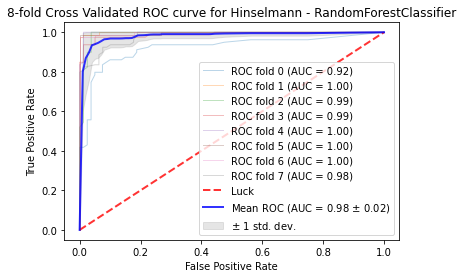

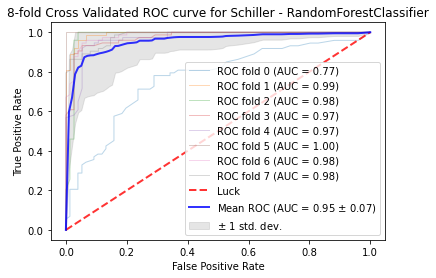

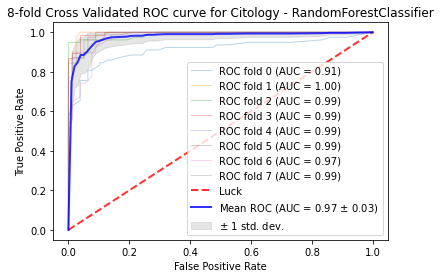

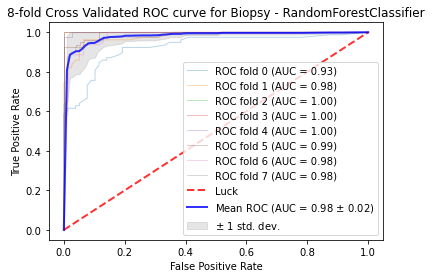

______________________________ 

 RandomForestClassifier 
 ______________________________


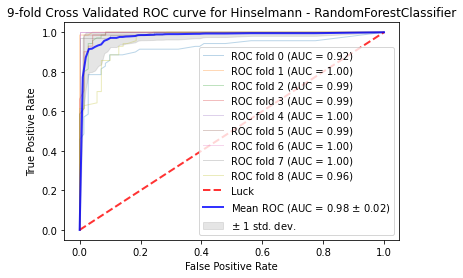

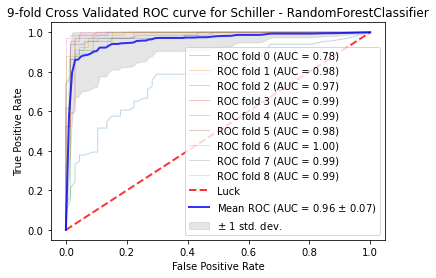

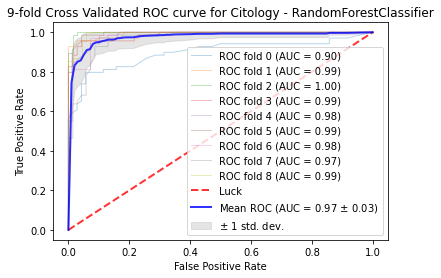

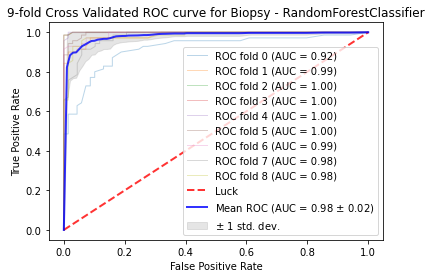

______________________________ 

 KNeighborsClassifier 
 ______________________________


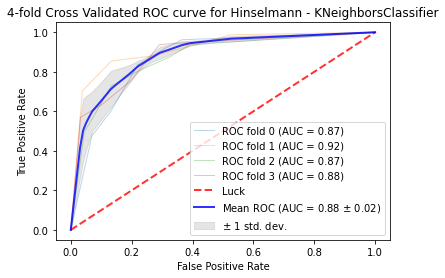

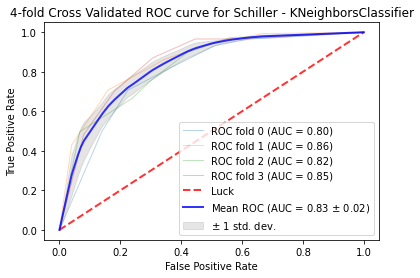

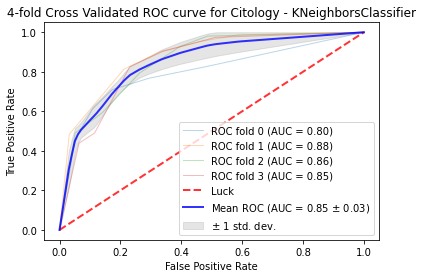

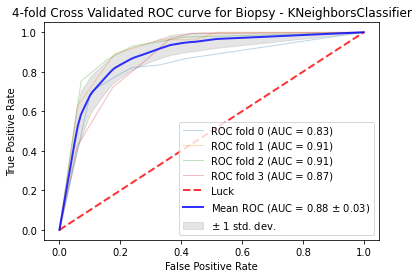

______________________________ 

 KNeighborsClassifier 
 ______________________________


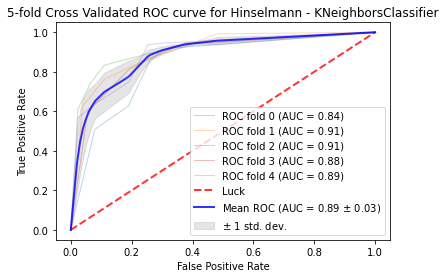

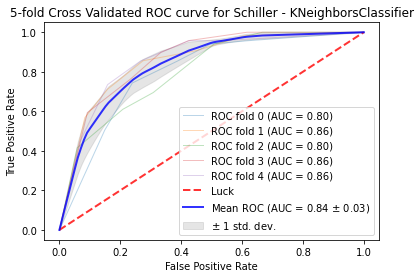

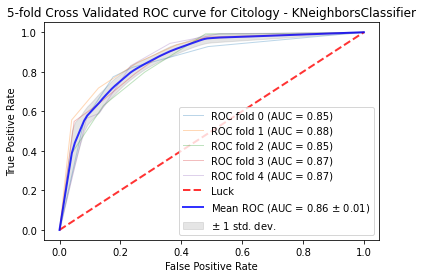

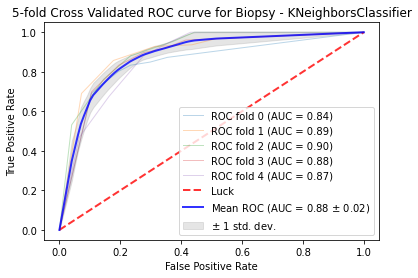

______________________________ 

 KNeighborsClassifier 
 ______________________________


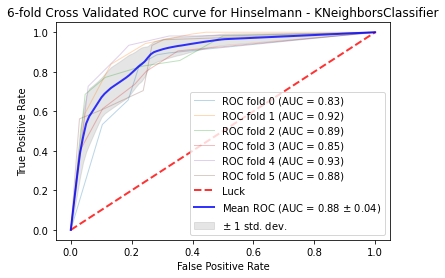

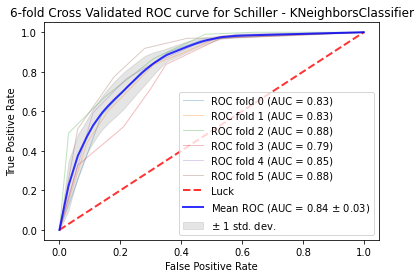

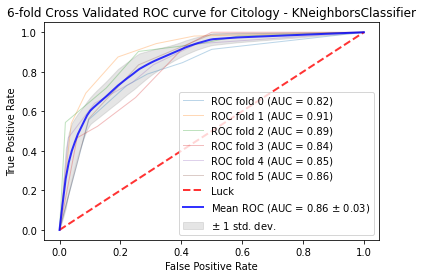

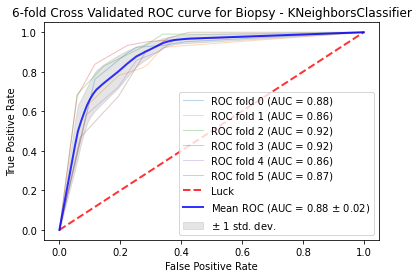

______________________________ 

 KNeighborsClassifier 
 ______________________________


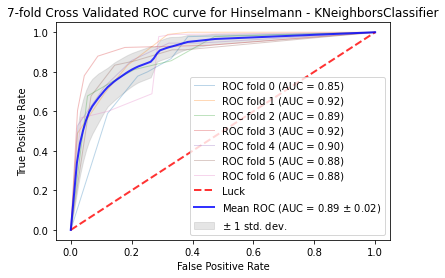

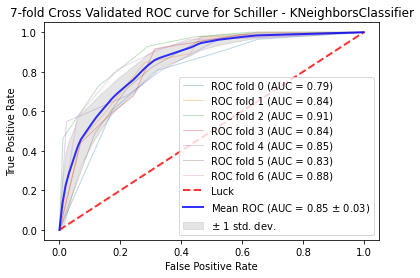

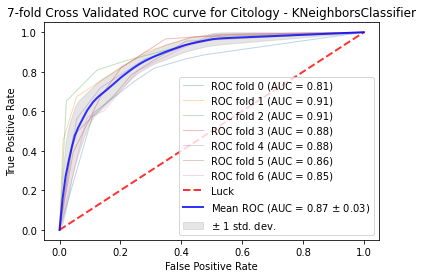

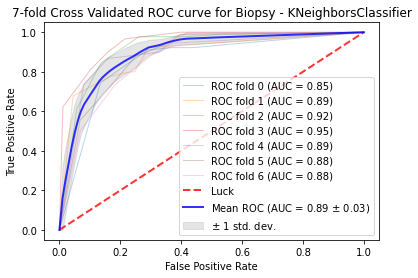

______________________________ 

 KNeighborsClassifier 
 ______________________________


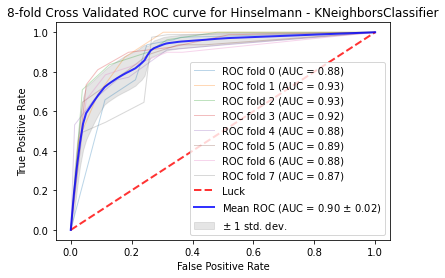

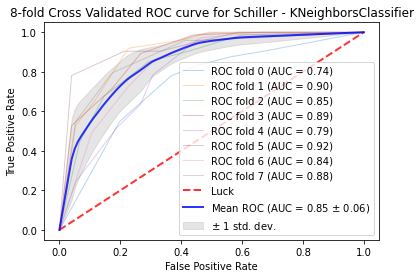

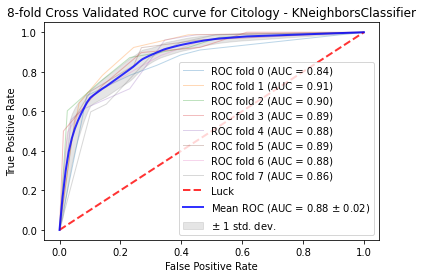

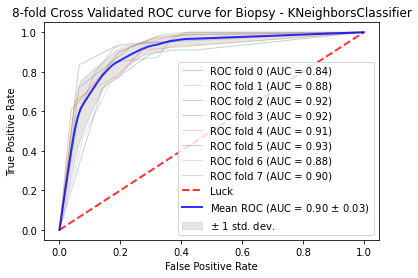

______________________________ 

 KNeighborsClassifier 
 ______________________________


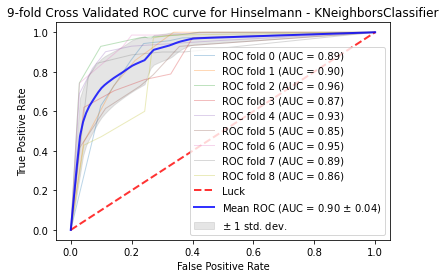

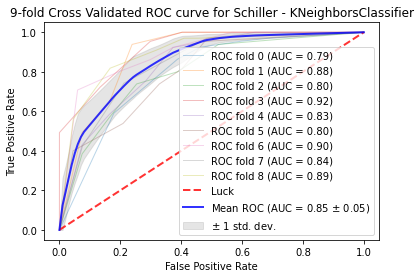

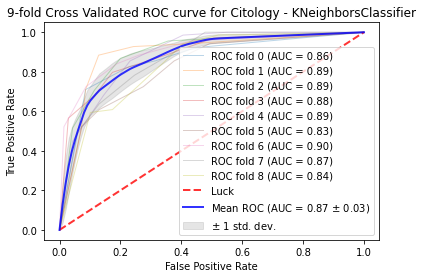

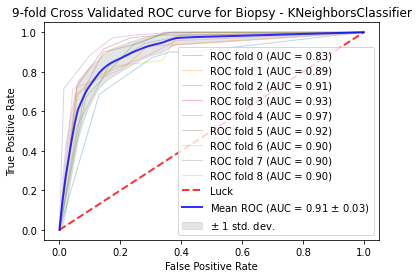

______________________________ 

 XGBClassifier 
 ______________________________


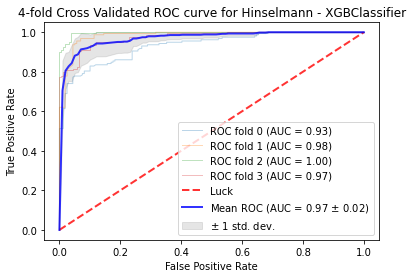

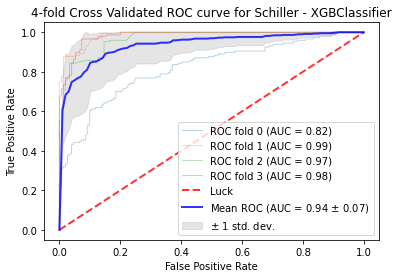

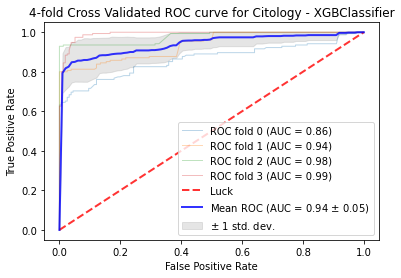

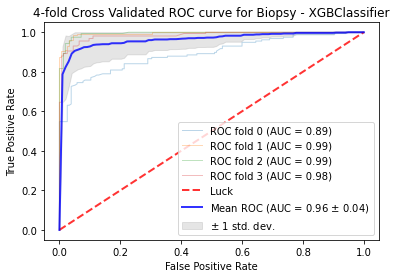

______________________________ 

 XGBClassifier 
 ______________________________


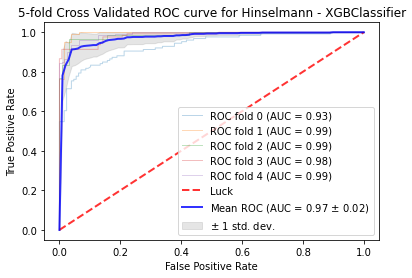

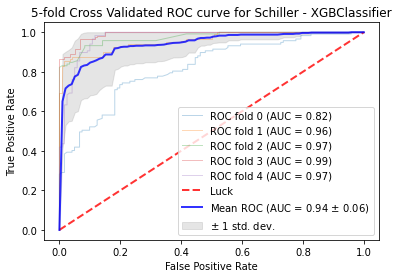

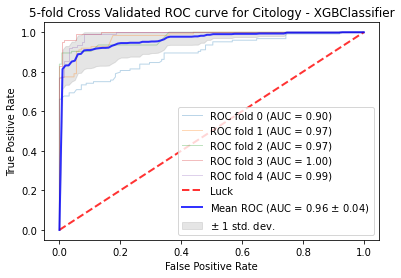

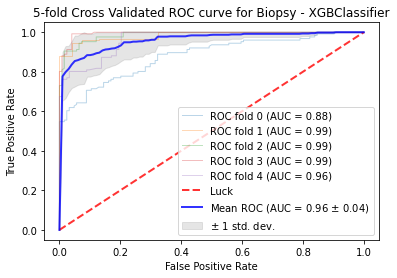

______________________________ 

 XGBClassifier 
 ______________________________


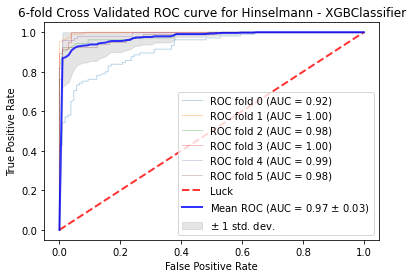

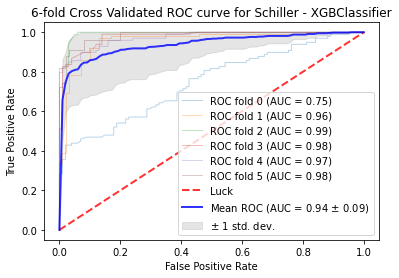

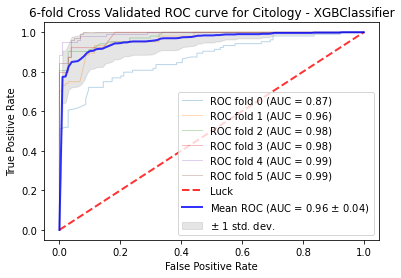

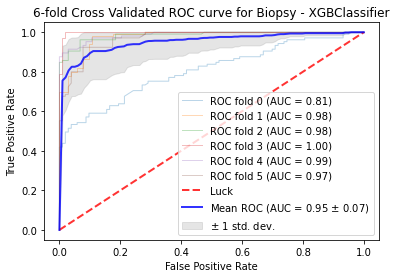

______________________________ 

 XGBClassifier 
 ______________________________


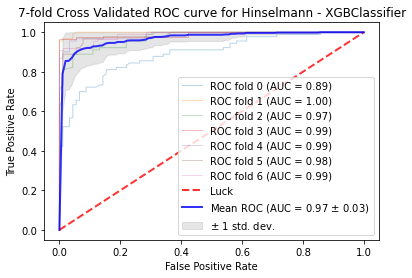

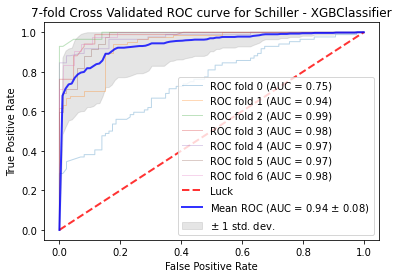

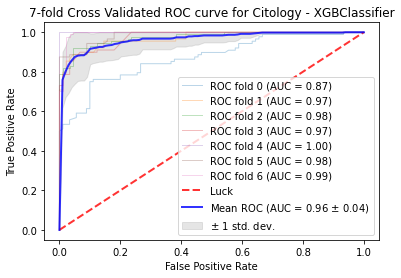

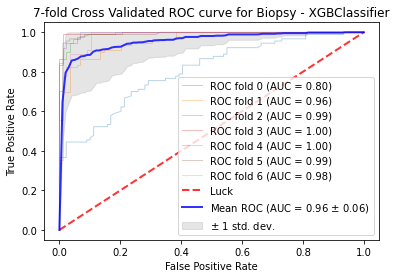

______________________________ 

 XGBClassifier 
 ______________________________


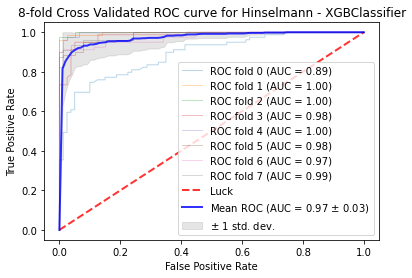

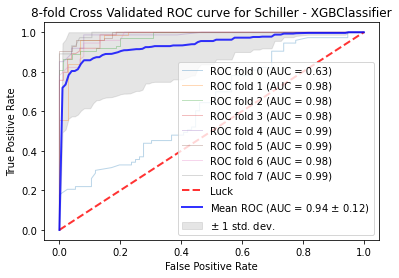

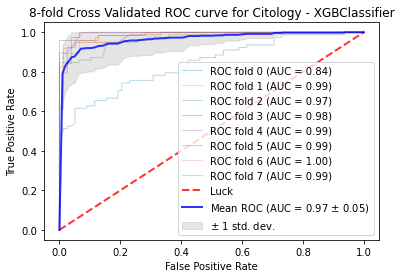

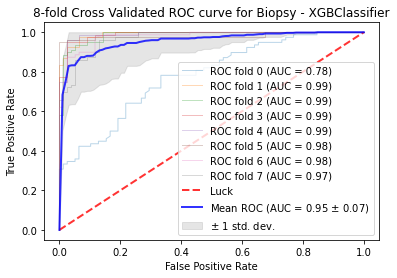

______________________________ 

 XGBClassifier 
 ______________________________


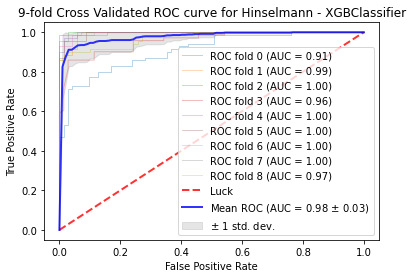

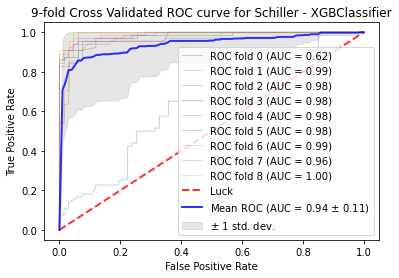

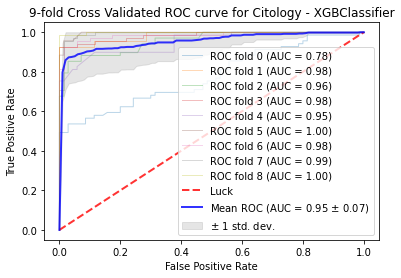

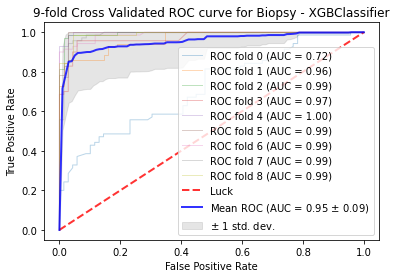

In [38]:
oversampled_data = [(X1_bal, y1_bal), (X2_bal, y2_bal), (X3_bal, y3_bal), (X4_bal, y4_bal)]
mean_scores_roc = {}
for clf in clfs:
    for cv in cvs:
        clf_name = get_classifier_name(clf)
        key = clf_name+str(cv.n_splits)
        #Add new keys with classifier name in the dictionary
        mean_scores_roc[key] = []
        print('_'*30,'\n\n',clf_name,'\n', '_'*30)
        for X_bal,target in oversampled_data:
            roc_title = str(cv.n_splits) + '-fold Cross Validated ROC curve for ' + target.columns.name + ' - ' + clf_name
            mean_scores_roc[key].append(draw_cv_roc_curve(clf, cv, X_bal, target, title=roc_title))

______________________________ 

 SVC 
 ______________________________


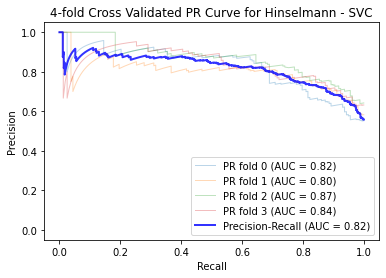

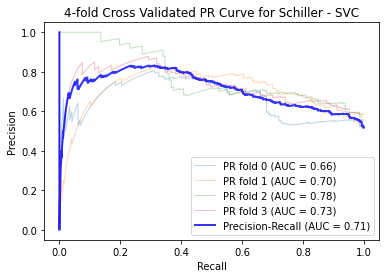

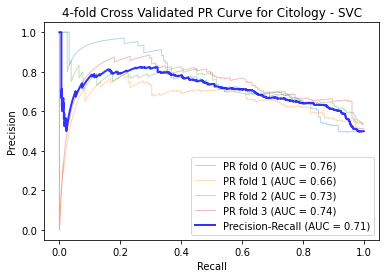

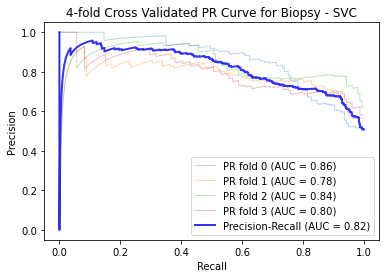

______________________________ 

 SVC 
 ______________________________


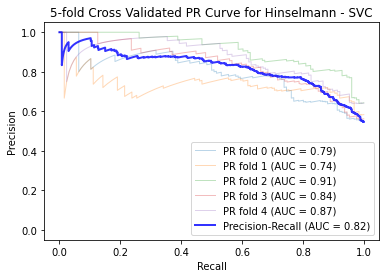

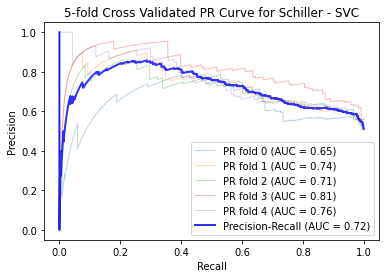

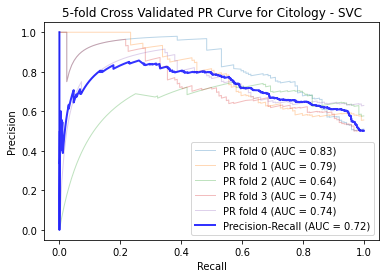

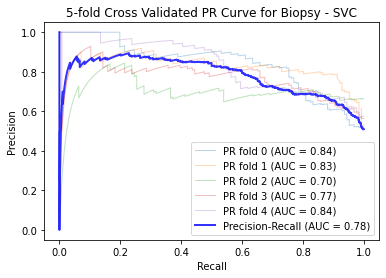

______________________________ 

 SVC 
 ______________________________


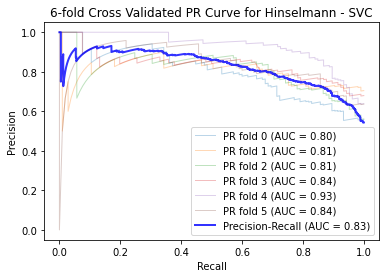

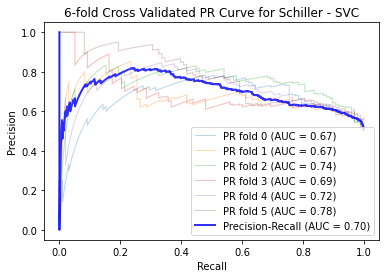

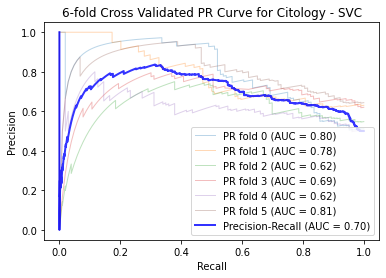

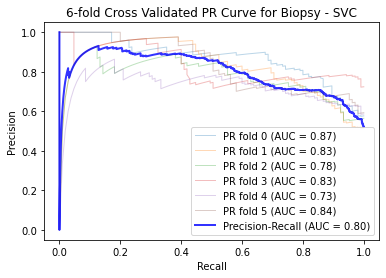

______________________________ 

 SVC 
 ______________________________


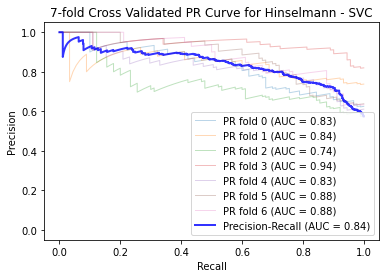

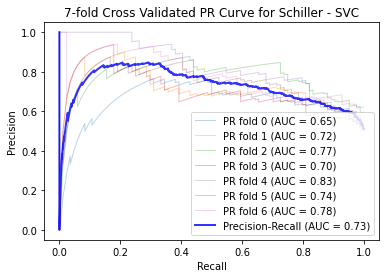

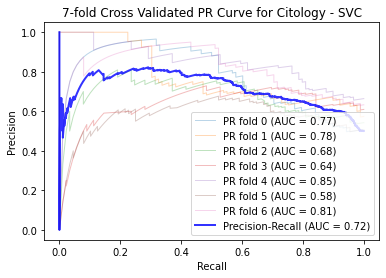

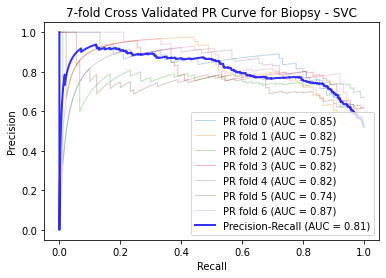

______________________________ 

 SVC 
 ______________________________


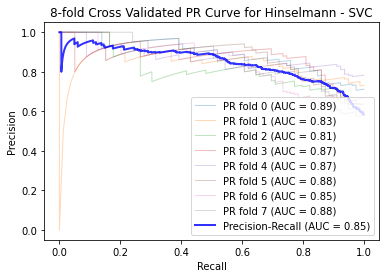

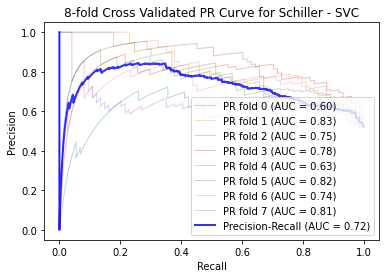

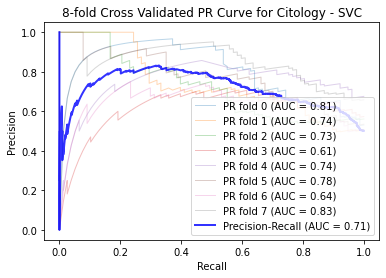

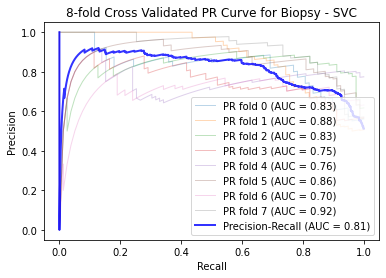

______________________________ 

 SVC 
 ______________________________


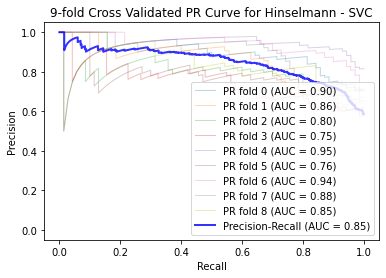

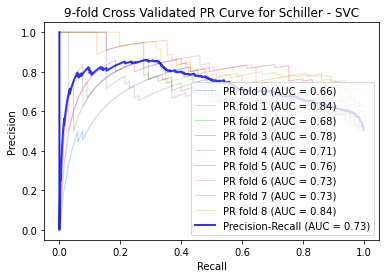

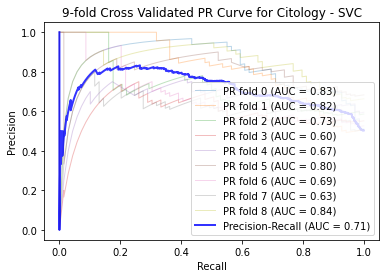

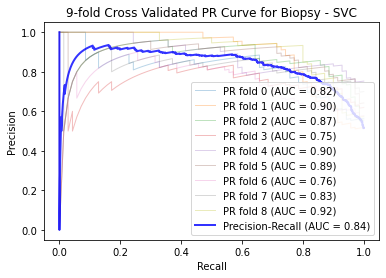

______________________________ 

 RandomForestClassifier 
 ______________________________


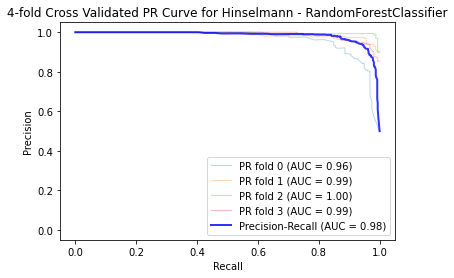

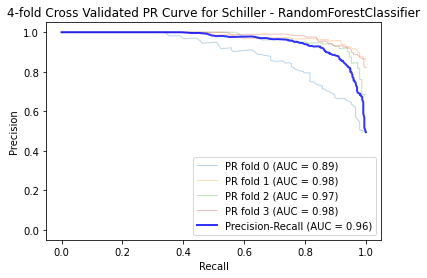

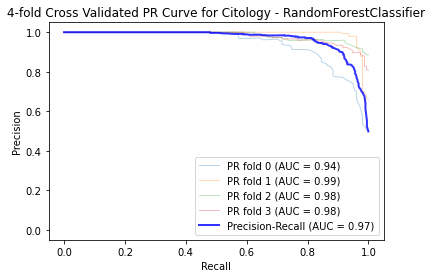

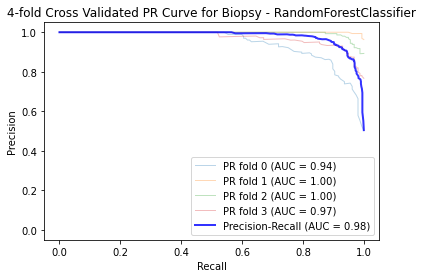

______________________________ 

 RandomForestClassifier 
 ______________________________


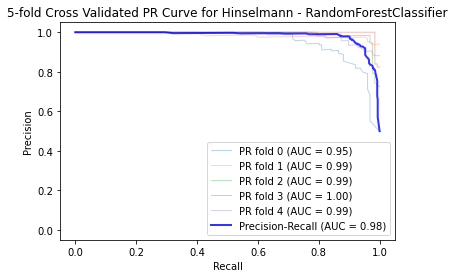

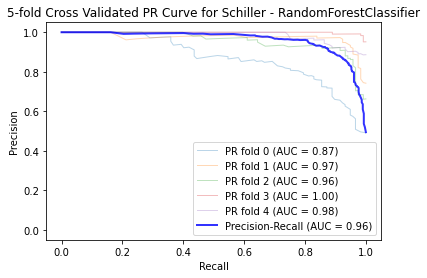

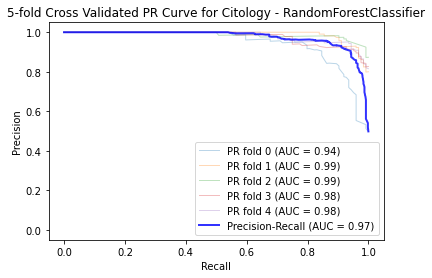

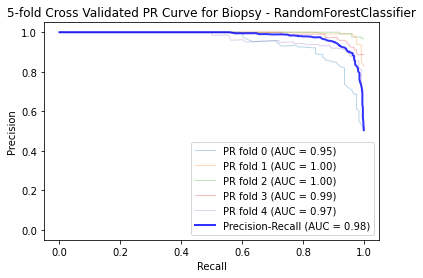

______________________________ 

 RandomForestClassifier 
 ______________________________


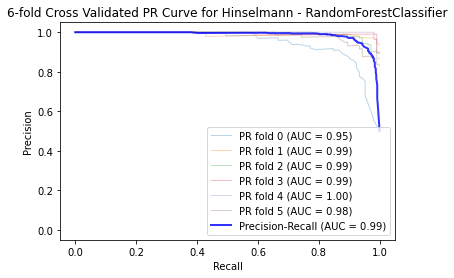

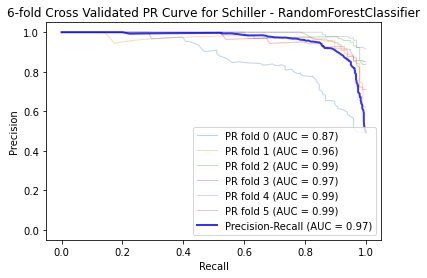

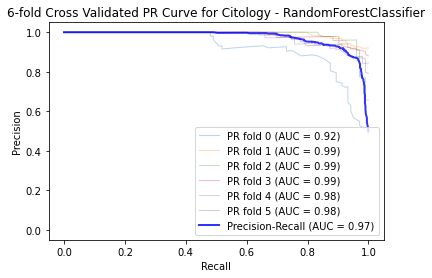

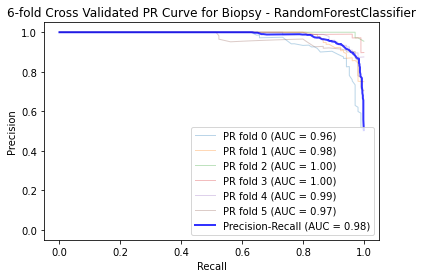

______________________________ 

 RandomForestClassifier 
 ______________________________


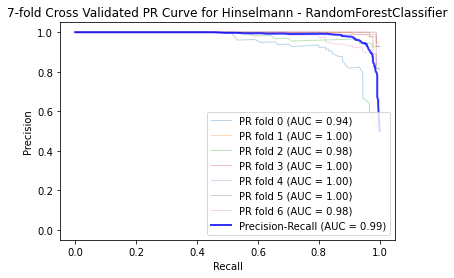

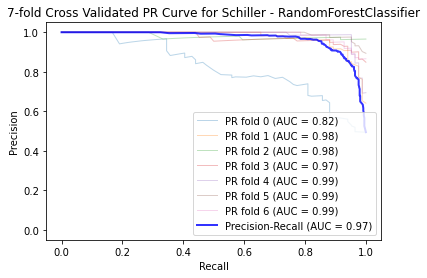

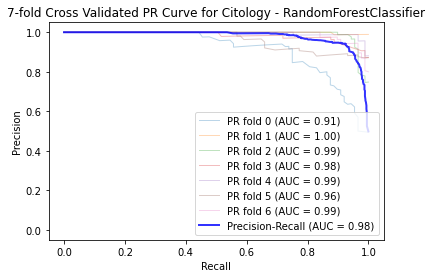

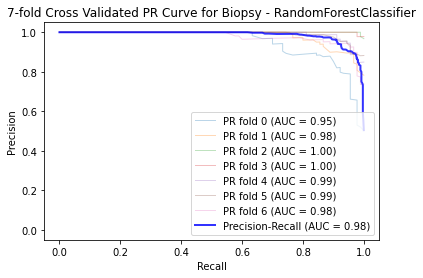

______________________________ 

 RandomForestClassifier 
 ______________________________


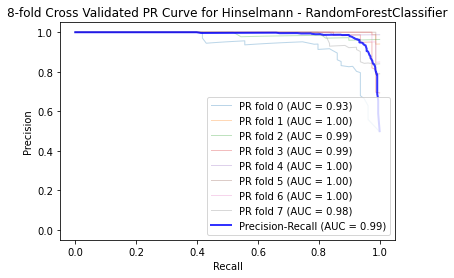

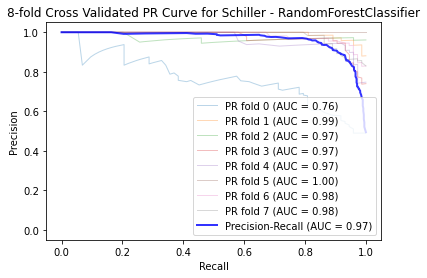

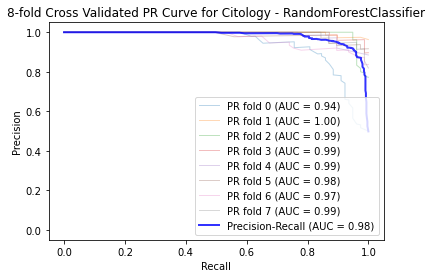

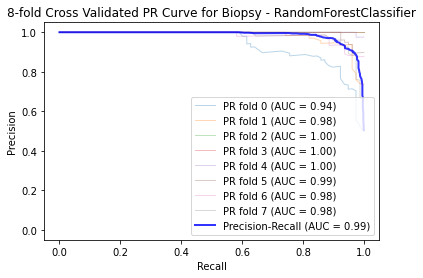

______________________________ 

 RandomForestClassifier 
 ______________________________


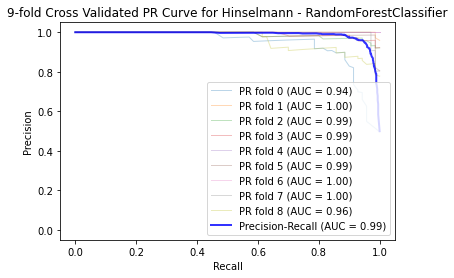

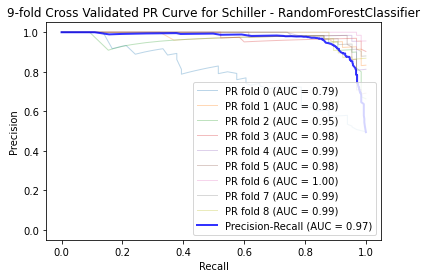

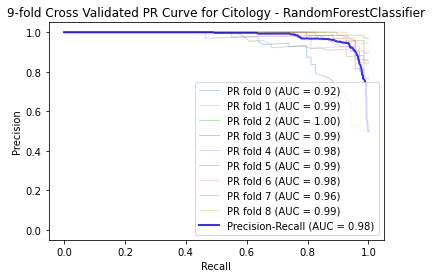

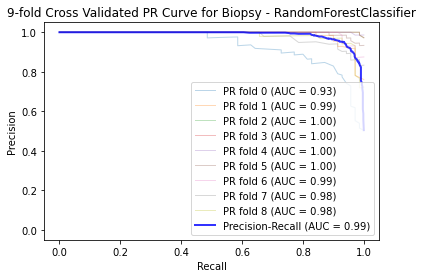

______________________________ 

 KNeighborsClassifier 
 ______________________________


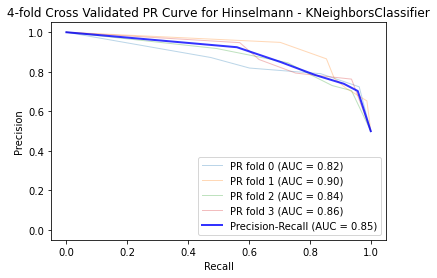

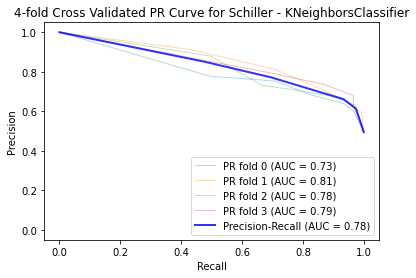

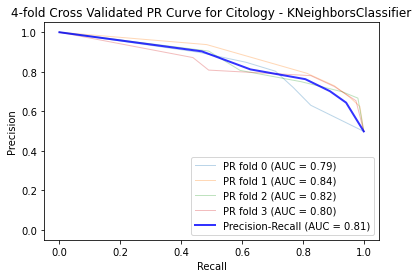

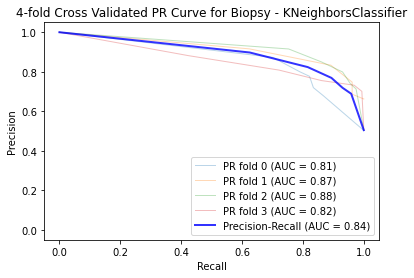

______________________________ 

 KNeighborsClassifier 
 ______________________________


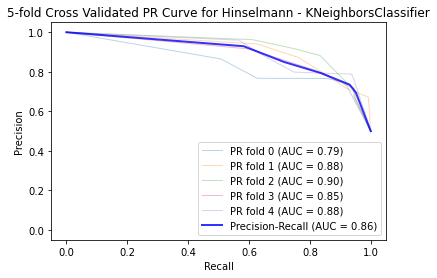

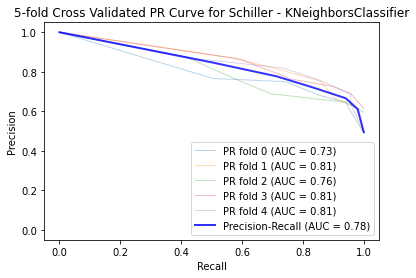

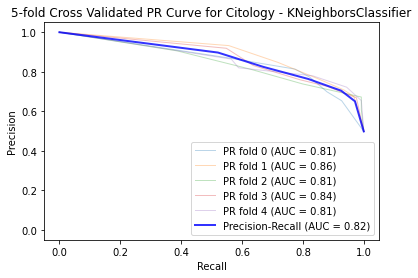

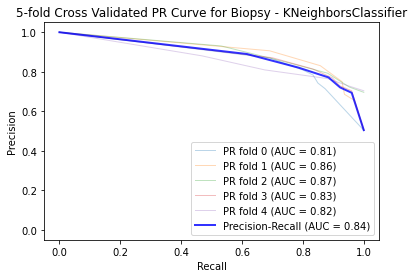

______________________________ 

 KNeighborsClassifier 
 ______________________________


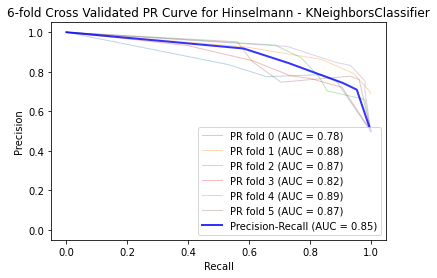

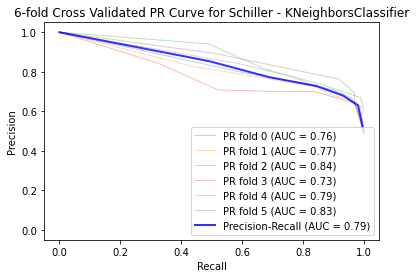

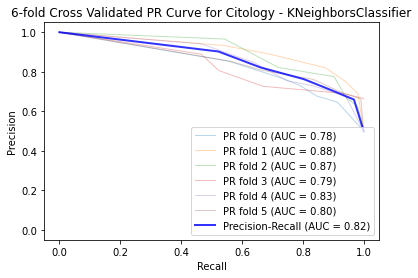

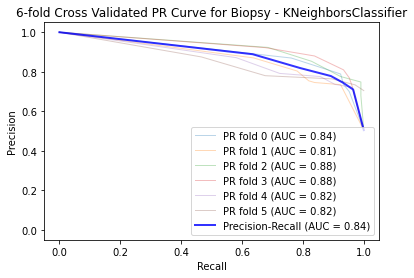

______________________________ 

 KNeighborsClassifier 
 ______________________________


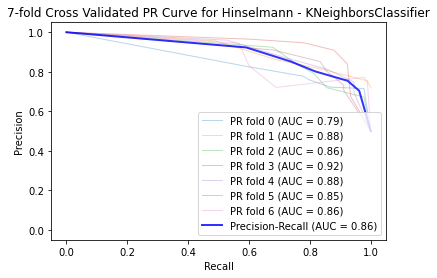

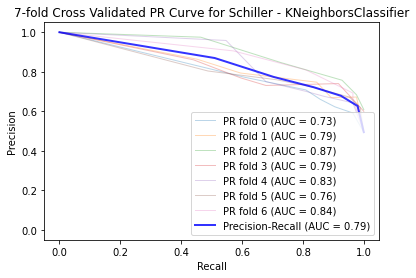

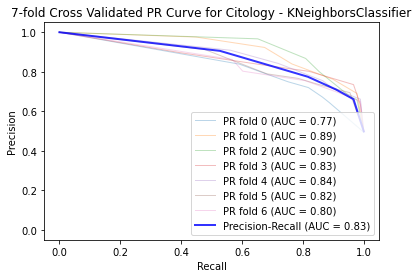

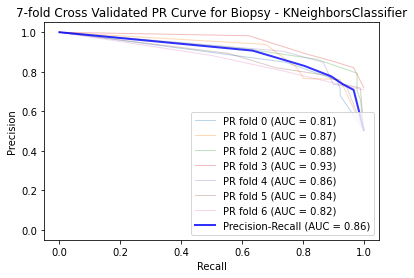

______________________________ 

 KNeighborsClassifier 
 ______________________________


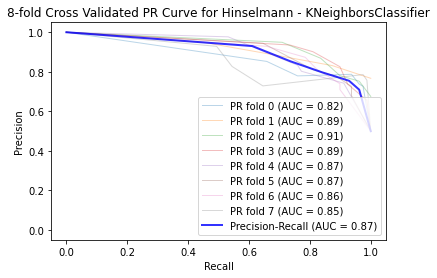

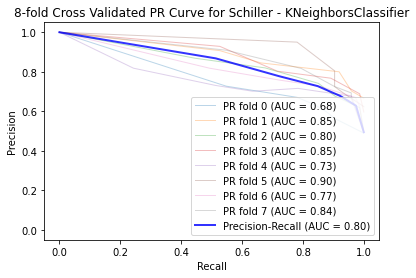

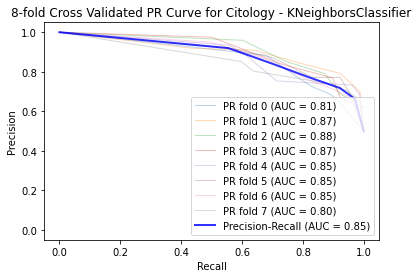

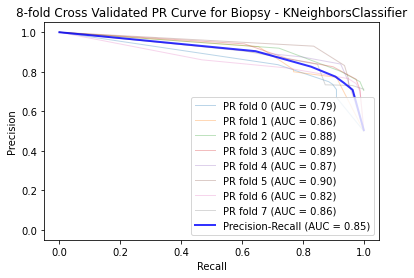

______________________________ 

 KNeighborsClassifier 
 ______________________________


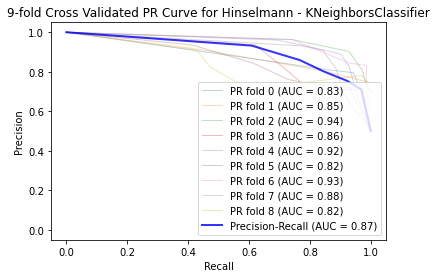

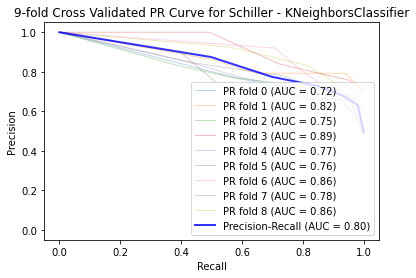

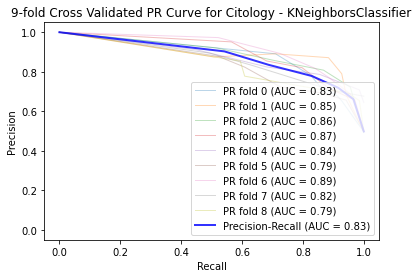

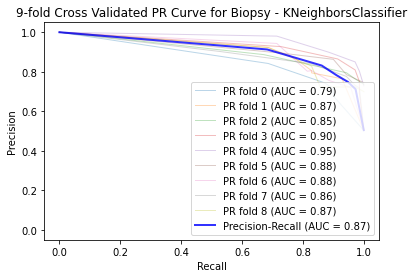

______________________________ 

 XGBClassifier 
 ______________________________


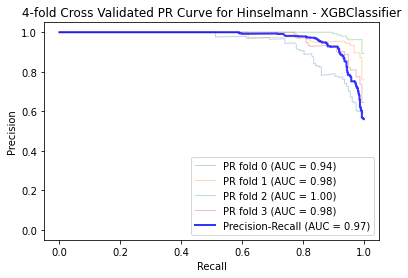

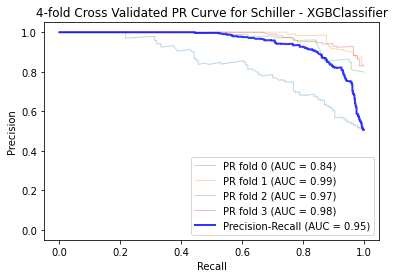

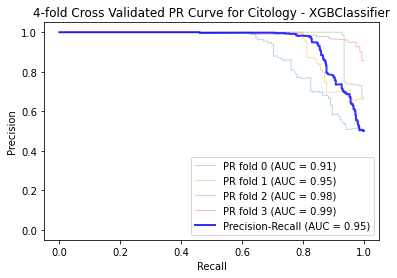

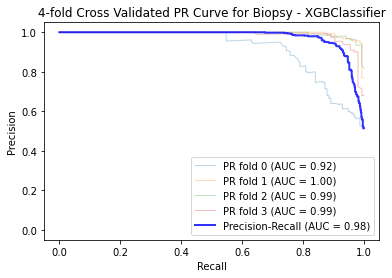

______________________________ 

 XGBClassifier 
 ______________________________


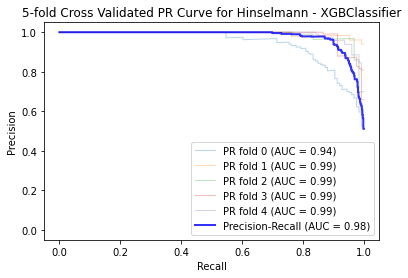

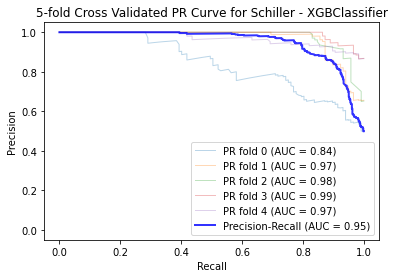

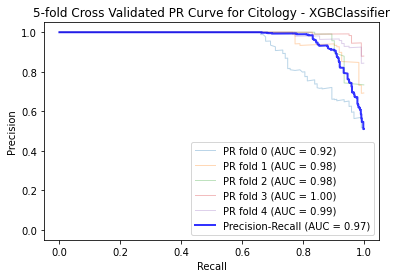

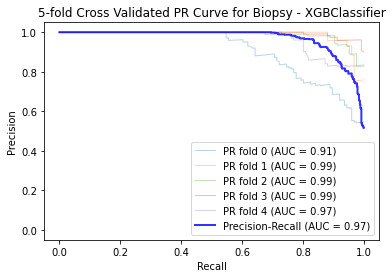

______________________________ 

 XGBClassifier 
 ______________________________


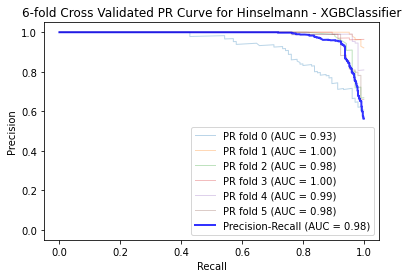

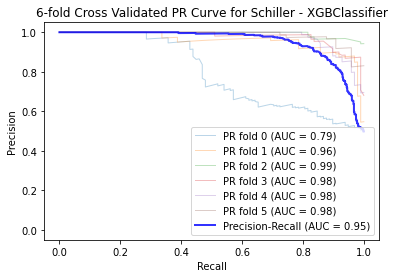

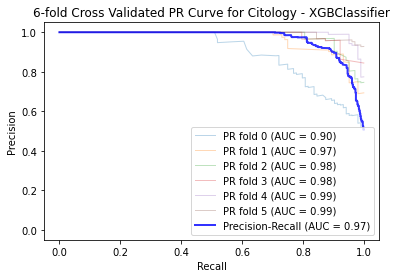

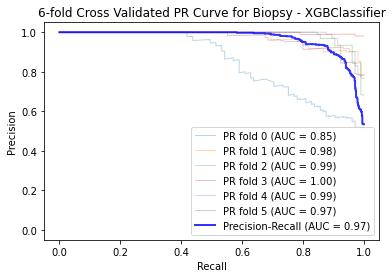

______________________________ 

 XGBClassifier 
 ______________________________


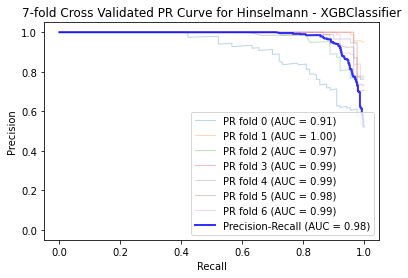

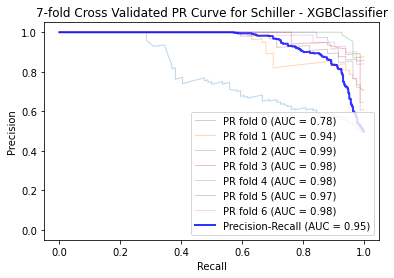

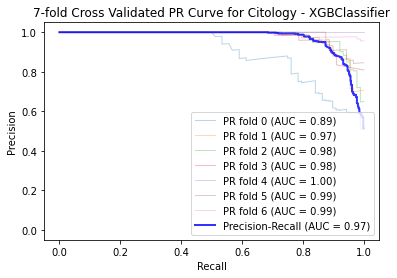

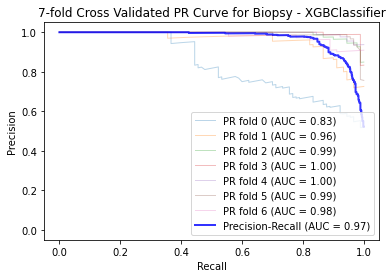

______________________________ 

 XGBClassifier 
 ______________________________


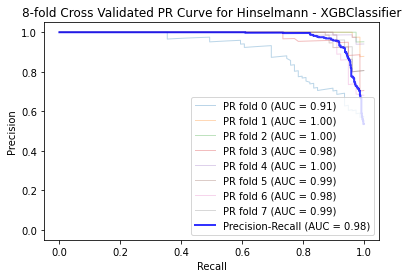

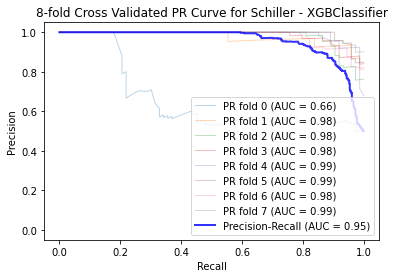

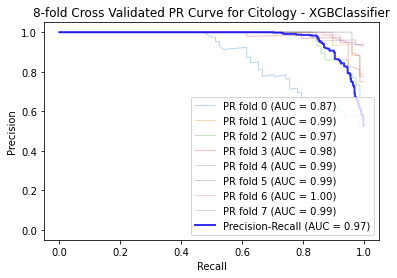

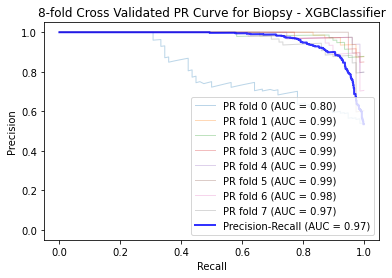

______________________________ 

 XGBClassifier 
 ______________________________


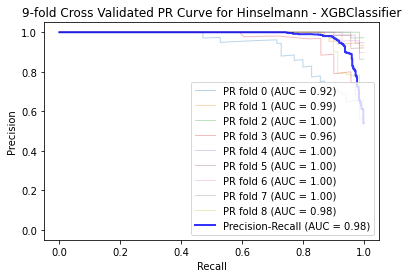

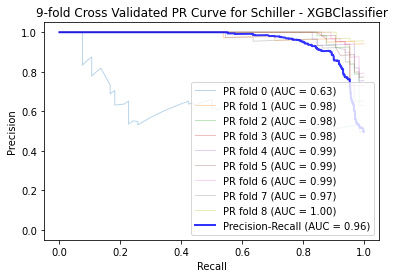

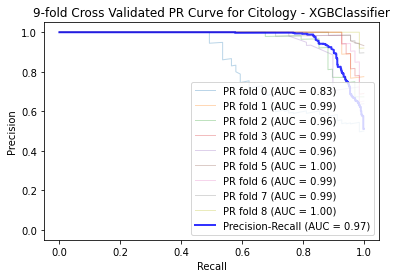

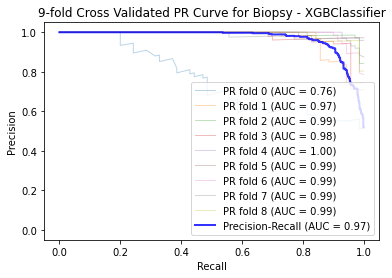

In [39]:
mean_scores_pr = {}
for clf in clfs:
    
    for cv in cvs:
        clf_name = get_classifier_name(clf)
        key = clf_name+str(cv.n_splits)
        
        mean_scores_pr[key] = []
        print('_'*30,'\n\n',clf_name,'\n', '_'*30)
        for X_bal,target in oversampled_data:
            pr_title = str(cv.n_splits) + '-fold Cross Validated PR Curve for ' + target.columns.name + ' - ' + clf_name
            mean_scores_pr[key].append(draw_cv_pr_curve(clf, cv, X_bal, target, title=pr_title))

In [40]:
# DataFrame to store classifier performance
performance_roc = pd.DataFrame(columns=targets)
for clf in clfs:
    for cv in cvs:
        key = get_classifier_name(clf)+str(cv.n_splits)
        performance_roc.loc[key,
                            targets] = mean_scores_roc[key]
print('_'*50,'\n\n', 'Table depicting ROC AUC scores', '\n', '_'*50)
    
performance_roc

__________________________________________________ 

 Table depicting ROC AUC scores 
 __________________________________________________


Hinselmann  Schiller  Citology    Biopsy
SVC4                      0.852801  0.758889  0.752041  0.835745
SVC5                      0.846039  0.768683  0.764625  0.817658
SVC6                       0.85961   0.76213  0.754547  0.828925
SVC7                      0.860189  0.782845  0.762758  0.835434
SVC8                      0.874025   0.78519  0.764945  0.845467
SVC9                      0.874297  0.782512  0.759179  0.863957
RandomForestClassifier4   0.980048  0.952138  0.967253  0.971813
RandomForestClassifier5   0.977728  0.954058  0.970326   0.97546
RandomForestClassifier6   0.981093  0.958079  0.967669  0.978237
RandomForestClassifier7   0.979871  0.954918  0.969259  0.977347
RandomForestClassifier8   0.979963  0.953603   0.97495  0.978676
RandomForestClassifier9    0.97985  0.959328   0.97342   0.97954
KNeighborsClassifier4     0.884053  0.831462   0.84575   0.88322
KNeighborsClassifier5      0.88654   0.83603  0.864035  0.878418
KNeighborsClassifier6     0.884645  0.842923  0.860848  0.884182
KNeighborsClassifier7     0.890995  0.848222  0.871309   0.89496
KNeighborsClassifier8     0.897444  0.851572  0.880522  0.896678
KNeighborsClassifier9     0.901436  0.849859  0.872676  0.906708
XGBClassifier4            0.968406  0.936625  0.938203  0.962574
XGBClassifier5            0.973406  0.940593   0.96209  0.958622
XGBClassifier6            0.974887  0.937369  0.959782  0.950325
XGBClassifier7            0.968456  0.938326  0.962927  0.955883
XGBClassifier8            0.972201  0.936578  0.965046  0.954652
XGBClassifier9            0.975787  0.938997  0.954399  0.952759

In [41]:
# DataFrame to store classifier performance
performance_roc = pd.DataFrame(columns=targets)
for clf in clfs:
    for cv in cvs:
        key = get_classifier_name(clf)+str(cv.n_splits)
        performance_roc.loc[key,
                            targets] = mean_scores_roc[key]
print('_'*50,'\n\n', 'Table depicting ROC AUC scores', '\n', '_'*50)
    
performance_roc

__________________________________________________ 

 Table depicting ROC AUC scores 
 __________________________________________________


Hinselmann  Schiller  Citology    Biopsy
SVC4                      0.852801  0.758889  0.752041  0.835745
SVC5                      0.846039  0.768683  0.764625  0.817658
SVC6                       0.85961   0.76213  0.754547  0.828925
SVC7                      0.860189  0.782845  0.762758  0.835434
SVC8                      0.874025   0.78519  0.764945  0.845467
SVC9                      0.874297  0.782512  0.759179  0.863957
RandomForestClassifier4   0.980048  0.952138  0.967253  0.971813
RandomForestClassifier5   0.977728  0.954058  0.970326   0.97546
RandomForestClassifier6   0.981093  0.958079  0.967669  0.978237
RandomForestClassifier7   0.979871  0.954918  0.969259  0.977347
RandomForestClassifier8   0.979963  0.953603   0.97495  0.978676
RandomForestClassifier9    0.97985  0.959328   0.97342   0.97954
KNeighborsClassifier4     0.884053  0.831462   0.84575   0.88322
KNeighborsClassifier5      0.88654   0.83603  0.864035  0.878418
KNeighborsClassifier6     0.884645  0.842923  0.860848  0.884182
KNeighborsClassifier7     0.890995  0.848222  0.871309   0.89496
KNeighborsClassifier8     0.897444  0.851572  0.880522  0.896678
KNeighborsClassifier9     0.901436  0.849859  0.872676  0.906708
XGBClassifier4            0.968406  0.936625  0.938203  0.962574
XGBClassifier5            0.973406  0.940593   0.96209  0.958622
XGBClassifier6            0.974887  0.937369  0.959782  0.950325
XGBClassifier7            0.968456  0.938326  0.962927  0.955883
XGBClassifier8            0.972201  0.936578  0.965046  0.954652
XGBClassifier9            0.975787  0.938997  0.954399  0.952759

In [42]:
# DataFrame to store classifier performance
performance_pr = pd.DataFrame(columns=targets)

for clf in clfs:
    for cv in cvs:
        key = get_classifier_name(clf)+str(cv.n_splits)
        performance_pr.loc[key,
                            targets] = mean_scores_pr[key]
print('_'*50,'\n\n', 'Table depicting Precision-Recall AUC scores', '\n', '_'*50)
    
performance_pr

__________________________________________________ 

 Table depicting Precision-Recall AUC scores 
 __________________________________________________


Hinselmann  Schiller  Citology    Biopsy
SVC4                      0.818306  0.708101  0.710845   0.81662
SVC5                      0.822629  0.718987  0.723883  0.781425
SVC6                      0.825027  0.700398  0.698751  0.798586
SVC7                      0.837001  0.725127  0.715435   0.81186
SVC8                      0.846418  0.723822  0.712929  0.812801
SVC9                      0.847806   0.73244  0.713631   0.83562
RandomForestClassifier4   0.982932  0.957989  0.967756   0.98004
RandomForestClassifier5   0.982567  0.961038   0.97315  0.981036
RandomForestClassifier6   0.985519  0.965258  0.973643  0.983959
RandomForestClassifier7   0.986301  0.967504  0.977322  0.984865
RandomForestClassifier8   0.986006  0.965387  0.981099  0.985618
RandomForestClassifier9   0.986891  0.968771  0.980471  0.986484
KNeighborsClassifier4     0.851849  0.776116  0.809814   0.84477
KNeighborsClassifier5     0.858104  0.781075  0.823122  0.837338
KNeighborsClassifier6     0.851435   0.78548   0.82255  0.841726
KNeighborsClassifier7     0.860631  0.793582  0.831163  0.855481
KNeighborsClassifier8     0.867394  0.795261  0.845027  0.854932
KNeighborsClassifier9     0.872879  0.796911   0.83384  0.869806
XGBClassifier4            0.972794  0.949595  0.953859  0.976139
XGBClassifier5            0.978405  0.948656  0.968938  0.969234
XGBClassifier6            0.979589  0.950736  0.967815  0.968197
XGBClassifier7            0.978707  0.949065  0.970495   0.96983
XGBClassifier8            0.980089  0.954595  0.971132  0.965165
XGBClassifier9            0.983027  0.957606  0.968352  0.969938

In [43]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

# Get feature names to be displayed
feat_names = X1_bal.columns.tolist()

# Select each classifier one by one
for clf in clfs:
    
    print('_'*40,'\n',get_classifier_name(clf),'\n', '_'*40)
    # PermutationImportance object for each classifier
    permuter = PermutationImportance(clf, scoring='roc_auc', cv='prefit', random_state=42)
    
    # Calculate feature importance for all 4 target variables
    for X_bal,y_bal in oversampled_data:
        permuter.fit(X_bal, y_bal)
        print('_'*40,'\n\n','Feature Importance (', y_bal.columns.name, ') - ', get_classifier_name(clf), '\n', '_'*40,'\n')
        display(eli5.show_weights(permuter, feature_names = feat_names))

________________________________________ 
 SVC 
 ________________________________________
________________________________________ 

 Feature Importance ( Hinselmann ) -  SVC 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Schiller ) -  SVC 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Citology ) -  SVC 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Biopsy ) -  SVC 
 ________________________________________ 



________________________________________ 
 RandomForestClassifier 
 ________________________________________
________________________________________ 

 Feature Importance ( Hinselmann ) -  RandomForestClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Schiller ) -  RandomForestClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Citology ) -  RandomForestClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Biopsy ) -  RandomForestClassifier 
 ________________________________________ 



________________________________________ 
 KNeighborsClassifier 
 ________________________________________
________________________________________ 

 Feature Importance ( Hinselmann ) -  KNeighborsClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Schiller ) -  KNeighborsClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Citology ) -  KNeighborsClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Biopsy ) -  KNeighborsClassifier 
 ________________________________________ 



________________________________________ 
 XGBClassifier 
 ________________________________________
________________________________________ 

 Feature Importance ( Hinselmann ) -  XGBClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Schiller ) -  XGBClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Citology ) -  XGBClassifier 
 ________________________________________ 



________________________________________ 

 Feature Importance ( Biopsy ) -  XGBClassifier 
 ________________________________________ 

